In [1]:
import numpy as np
from multi_task.util import util
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import statsmodels.api as sm
import statsmodels.formula.api as smf

from rdrobust import rdrobust, rdbwselect, rdplot
from sklearn.metrics import pairwise_distances

from joblib import Parallel, delayed

from tigramite.independence_tests.parcorr import ParCorr
from util.util import layers_bn_afterrelu, layers_bn_prerelu

from rcot.independence import rcot, rcot_100

/mnt/antares_raid/home/spiess/projects/structure-for-interpretability/multi_task/util/util.py:21: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift
/mnt/antares_raid/home/spiess/projects/structure-for-interpretability/multi_task/util/util.py:21: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.


Look at RDD again. Plot the logs of class probs over the activations of a neuron. Start with high layers.

Set some threshold as some samples will have very low log probs.

Compute 'gradient' as well (diff logs / diff activations)

Check: https://causalpy.readthedocs.io/en/latest/notebooks/rd_pymc_drinking.html

# Setup

In [51]:
LOCAL_STORAGE = "local_storage"

activations_dict = np.load(f"{LOCAL_STORAGE}/activations_on_validation_averaged_spatial_bettercifar10single_afterrelu.npy", allow_pickle=True).item()
logits = np.vstack(activations_dict['logits'])
layers = activations_dict['target_layer_names']

labels = np.load(f"{LOCAL_STORAGE}/labels_bettercifar10single_afterrelu.npy")
predicted_labels = logits.argmax(axis=1)

In [3]:
(predicted_labels == labels).sum() / len(labels)

0.9252

In [4]:
def produce_df_class(activations_dict, layers, labels, logits, layeri, neuroni, classi, quantile=None):
    acts = np.vstack(activations_dict[layers[layeri]])[:, neuroni]

    selection = labels == classi
    
    if quantile is not None:
        print("Should not use quantile=True` for passing it to `rdrobust`!")

        class_acts = acts[selection]

        try:
            xlims_class = -np.quantile(np.abs(class_acts[class_acts < 0]), quantile), np.quantile(np.abs(class_acts[class_acts > 0]), quantile)
        except:
            return None, None
        
        inlims_class = np.logical_and(acts >= xlims_class[0], acts <= xlims_class[1])

        selection = np.logical_and(selection, inlims_class)

    class_acts = acts[selection]
    logits_class = logits[:, classi][selection]

    probs = F.softmax(torch.tensor(logits), dim=1).numpy()
    probs_class = probs[:, classi][selection]

    logprobs_class = np.log(probs_class)

    domain_class = np.array(["Above threshold" if a >= 0 else "Below threshold" for a in class_acts])

    df_class = pd.DataFrame({"Probs.": probs_class,
                   "Logits": logits_class, "Log. Probs.": logprobs_class,
                   "Activations": class_acts, "Domain": domain_class})
    if quantile is not None:
        return df_class, xlims_class
    else:
        return df_class

In [5]:
def produce_df_class_logits(activations_dict, layers, logits, layeri, neuroni, classi):
    acts = np.vstack(activations_dict[layers[layeri]])[:, neuroni]

    logits_class = logits[:, classi]

    probs = F.softmax(torch.tensor(logits), dim=1).numpy()
    probs_class = probs[:, classi]

    logprobs_class = np.log(probs_class)

    domain_class = np.array(["Above threshold" if a >= 0 else "Below threshold" for a in acts])

    df_class = pd.DataFrame({"Probs.": probs_class,
                   "Logits": logits_class, "Log. Probs.": logprobs_class,
                   "Activations": acts, "Domain": domain_class})
    return df_class


In [6]:
def produce_df_max_class(activations_dict, layers, logits, layeri, neuroni, quantile=None):
    acts = np.vstack(activations_dict[layers[layeri]])[:, neuroni]
    
    selection = acts == acts

    if quantile is not None:
        print("Should not use quantile=True` for passing it to `rdrobust`!")

        try:
            xlims = -np.quantile(np.abs(acts[acts < 0]), quantile), np.quantile(np.abs(acts[acts > 0]), quantile)
        except:
            return None, None
        
        inlims = np.logical_and(acts >= xlims[0], acts <= xlims[1])

        selection = inlims

    acts = acts[selection]
    logits_max_class = logits.max(axis=1)[selection]

    probs = F.softmax(torch.tensor(logits), dim=1).numpy()
    probs_max_class = probs.max(axis=1)[selection]

    domain = np.array(["Above threshold" if a >= 0 else "Below threshold" for a in acts])

    df = pd.DataFrame({"Probs.": probs_max_class,
                   "Logits": logits_max_class,
                   "Activations": acts, "Domain": domain})
    if quantile is not None:
        return df, xlims
    else:
        return df

In [7]:
def produce_df_class_feature_relevance(activations_dict, layers, labels, logits, layeri, neuroni, classi, softmax_temperature=1.0):
    acts = np.vstack(activations_dict[layers[layeri]])[:, neuroni]

    selection_in_class = labels == classi
    selection_out_class = labels != classi

    acts_in_class = acts[selection_in_class]
    logits_in_class = logits[:, classi][selection_in_class]

    acts_out_class = acts[selection_out_class]
    logits_out_class = logits[selection_out_class, labels[selection_out_class]]
    logits_out_class_max = np.max(logits, axis=1)[selection_out_class]


    probs = F.softmax(torch.tensor(logits) * softmax_temperature, dim=1).numpy()
    probs_in_class = probs[:, classi][selection_in_class]
    probs_out_class = (1 - probs[:, classi])[selection_out_class]

    acts_all = np.concatenate([acts_in_class, acts_out_class])
    logits_all = np.concatenate([logits_in_class, logits_out_class])
    logits_all_max = np.concatenate([logits_in_class, logits_out_class_max])
    probs_all = np.concatenate([probs_in_class, probs_out_class])

    domain = np.array(["Above threshold" if a >= 0 else "Below threshold" for a in acts_all])
    
    classes = np.concatenate([np.zeros_like(acts_in_class, dtype=int), np.ones_like(acts_out_class, dtype=int)])
    classes_one_hot = np.eye(2)[classes]

    df = pd.DataFrame({"Probs.": probs_all,
                       "Logits": logits_all,
                   "Logits max.": logits_all_max,
                   "Activations": acts_all, "Classes": classes_one_hot.tolist(), "Domain": domain})
    
    return df

In [8]:
def estimate_rdd_effect(y, x, alpha=0.05, bwselect='mserd'):
    try:
        out = rdrobust(y=y, x=x, bwselect=bwselect)
    except Exception as e:
        print("rdorobust failed")
        return np.nan

    pval = out.pv.loc["Robust"][0]

    if pval >= alpha:
        est = np.nan
    else:
        cis = out.ci.loc["Robust"].to_numpy()

        # if they have different signs, use the middle
        all_same = np.all(np.sign(cis) == np.sign(cis)[0])
        if all_same:
            est = np.abs(cis).min() * np.sign(cis)[0]
        else:
            est = np.mean(cis)

    return est

In [9]:
def triangular_kernel(R, c, hs):
    if R < 0:
        h = np.abs(hs[0])
    else:
        h = np.abs(hs[1])

    indicator = (np.abs(R-c) <= h).astype(float)
    return indicator * (1 - np.abs(R-c)/h)

In [10]:
def fit_binomial_GLM(y, X, print_summary=False):
    
    pval, coef, std_err = np.nan, np.nan, np.nan
    significant_005 = False
    
    try:
        glm_binom = sm.GLM(y, X, family=sm.families.Binomial())
        res = glm_binom.fit()

        pval, coef, std_err = res.pvalues['Activations'], res.params['Activations'], res.bse['Activations']
        significant_005 = pval < 0.05

        if print_summary:
            print(res.summary())
    except:
        print("Computing binomial GLM failed!")

    d = {'Estimate': coef, 'Estimate Std.': std_err, 'Estimate pvalue': pval, 'Estimate significant (alpha=0.05)': significant_005}

    return d

def fit_OLS(y, X, print_summary=False):

    pval, coef, std_err = np.nan, np.nan, np.nan
    significant_005 = False

    pval_intercept, coef_intercept, std_err_intercept = np.nan, np.nan, np.nan
    significant_005_intercept = False

    rsquared = np.nanmean

    try:
        X_ = sm.add_constant(X)
        ols = sm.OLS(y, X_)
        res = ols.fit()

        pval, coef, std_err = res.pvalues['Activations'], res.params['Activations'], res.bse['Activations']
        significant_005 = pval < 0.05

        pval_intercept, coef_intercept, std_err_intercept = res.pvalues['const'], res.params['const'], res.bse['const']
        significant_005_intercept = pval_intercept < 0.05

        rsquared = res.rsquared

        if print_summary:
            print(res.summary())
    except:
        print("Computing OLS failed!")

    d = {'Estimate': coef, 'Estimate Std.': std_err, 'Estimate pvalue': pval, 'Estimate significant (alpha=0.05)': significant_005, 'Intercept': coef_intercept, 'Intercept Std.': std_err_intercept, 'Intercept pvalue': pval_intercept, 'Intercept significant (alpha=0.05)': significant_005_intercept, 'R-squared': rsquared}

    return d

def pos_full_activations_regression(df_class):
    X_full = df_class['Activations']
    X_pos = df_class['Activations'][df_class['Activations'] > 0]

    y_full = df_class['Probs.']
    y_pos = df_class['Probs.'][df_class['Activations'] > 0]

    data = [(y_pos, X_pos), (y_full, X_full)]

    pos_res, full_res = [fit_OLS(y, X) for (y, X) in data]
    return pos_res, full_res
    

In [11]:
def est_left_right(df_class, xlims_class):
    if df_class is None:
        return np.nan, np.nan

    weights = np.array([triangular_kernel(a, 0.0, xlims_class) for a in df_class['Activations']])
    left = df_class['Activations'] < 0
    right = df_class['Activations'] > 0

    if left.sum() == 0 or right.sum() == 0:
        return np.nan, np.nan

    X_left = sm.add_constant(df_class['Activations'][left])
    y_left = df_class['Logits'][left]

    X_right = sm.add_constant(df_class['Activations'][right])
    y_right = df_class['Logits'][right]

    res_wls_left = sm.WLS(y_left, X_left, weights=weights[left]).fit()
    res_wls_right = sm.WLS(y_right, X_right, weights=weights[right]).fit()

    est_left = res_wls_left.predict([1, 0])[0]
    est_right = res_wls_right.predict([1, 0])[0]

    return est_left, est_right

In [12]:
def bootstrapped_rdd(df_class, xlims_class, bootn=1000, njobs=4):
    if df_class is None:
        return np.nan, np.nan

    results = Parallel(n_jobs=njobs)(delayed(est_left_right)(df_class.sample(frac=1, replace=True), xlims_class)
                          for _ in range(bootn))
    results = np.array(results)
    diffs = results[:, 1, np.newaxis] - results[np.newaxis, :, 0]
    return np.nanmean(diffs), np.nanstd(diffs)

In [13]:
def est_pcorr(df_class_fr, on="Probs."):
    pval, coef = np.nan, np.nan
    significant_005 = False

    try:
        XY = df_class_fr[["Activations", on]].to_numpy()
        Z = np.vstack(df_class_fr["Classes"].to_numpy())
        XYZ = np.hstack([XY, Z]).T

        coef = ParCorr().get_dependence_measure(XYZ, None)
        pval = ParCorr().get_analytic_significance(coef, XYZ.shape[1], XYZ.shape[0], None)

        significant_005 = pval < 0.05
    except:
        print("Computing ParCorr failed!")

    d = {'Estimate': coef, 'Estimate pvalue': pval, 'Estimate significant (alpha=0.05)': significant_005}

    return d

def est_rcot(df_class_fr):
    pval, coef = np.nan, np.nan
    significant_005 = False

    try:
        XY = df_class_fr[["Activations", "Probs."]].to_numpy()
        Z = np.vstack(df_class_fr["Classes"].to_numpy())
        XYZ = np.hstack([XY, Z])

        coef, pval = rcot(XYZ[:, 0], XYZ[:, 1], XYZ[:, 2:], approx="hbe")

        significant_005 = pval < 0.05
    except:
        print("Computing RCOT failed!")

    d = {'Estimate': coef, 'Estimate pvalue': pval, 'Estimate significant (alpha=0.05)': significant_005}

    return d

# Linear Regression Experiments

What have I really computed here?

For activations vs. logits of samples of a class: Does not mean too much!

I should consider all logits of that class.


For activations vs. max logits of all samples: This is more like if a neuron is in general inhibitory or excitatory.

## Load regressions

In [34]:
# OLD, and unnecessary to compute, see comment in the corresponding section
# est_regression_df_pos_acts_class_true = pd.read_csv("local_storage/cifar10_est_regression_df_pos_acts_class_true_afterrelu.csv")
# est_regression_df_full_acts_class_true = pd.read_csv("local_storage/cifar10_est_regression_df_full_acts_class_true_afterrelu.csv")
# est_regression_df_pos_acts_class_predicted = pd.read_csv("local_storage/cifar10_est_regression_df_pos_acts_class_predicted_afterrelu.csv")
# est_regression_df_full_acts_class_predicted = pd.read_csv("local_storage/cifar10_est_regression_df_full_acts_class_predicted_afterrelu.csv")

est_regression_df_pos_acts_class_logits = pd.read_csv("local_storage/cifar10_est_regression_df_pos_acts_class_logits_afterrelu.csv")
est_regression_df_full_acts_class_logits = pd.read_csv("local_storage/cifar10_est_regression_df_full_acts_class_logits_afterrelu.csv")

est_regression_df_pos_acts_max_class = pd.read_csv("local_storage/cifar10_est_regression_df_pos_acts_max_class_afterrelu.csv")
est_regression_df_full_acts_max_class = pd.read_csv("local_storage/cifar10_est_regression_df_full_acts_max_class_afterrelu.csv")

In [35]:
significant_estimates = est_regression_df_pos_acts_class_logits[est_regression_df_pos_acts_class_logits["Estimate significant (alpha=0.05)"]]
(significant_estimates["Estimate"] < 0).sum()/len(significant_estimates), (significant_estimates["Estimate"] > 0).sum()/len(significant_estimates)
significant_estimates['Class'] = pd.Categorical(significant_estimates['Class'])

/tmp/ipykernel_13689/2911821969.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [36]:
est_regression_df_pos_acts_class_logits

Unnamed: 0  Layer Layername  Neuron  Class  Estimate  Estimate Std.   
0               0      0  layer1.0       0      0  0.269276       0.007238  \
1               1      0  layer1.0       0      1 -0.022343       0.007689   
2               2      0  layer1.0       0      2 -0.042385       0.007430   
3               3      0  layer1.0       0      3  0.000907       0.007688   
4               4      0  layer1.0       0      4 -0.118548       0.007463   
...           ...    ...       ...     ...    ...       ...            ...   
37855       37855     15    logits       9      5 -0.000981       0.000138   
37856       37856     15    logits       9      6 -0.001213       0.000162   
37857       37857     15    logits       9      7 -0.001693       0.000186   
37858       37858     15    logits       9      8 -0.006797       0.000388   
37859       37859     15    logits       9      9  0.024975       0.000240   

       Estimate pvalue  Estimate significant (alpha=0.05)  Intercept   
0        7.997190e-284                               True  -0.133005  \
1         3.670454e-03                               True   0.120248   
2         1.200924e-08                               True   0.132952   
3         9.060864e-01                              False   0.103696   
4         3.920161e-56                               True   0.201804   
...                ...                                ...        ...   
37855     1.622741e-12                               True   0.033830   
37856     7.783742e-14                               True   0.043634   
37857     1.522892e-19                               True   0.060045   
37858     6.169078e-66                               True   0.281671   
37859     0.000000e+00                               True  -0.117499   

       Intercept Std.  Intercept pvalue  Intercept significant (alpha=0.05)   
0            0.006930      1.188346e-80                                True  \
1            0.007361      3.253001e-59                                True   
2            0.007114      1.201874e-76                                True   
3            0.007360      1.196471e-44                                True   
4            0.007145     6.418733e-169                                True   
...               ...               ...                                 ...   
37855        0.003123      6.385897e-27                                True   
37856        0.003651      2.647415e-32                                True   
37857        0.004202      4.549158e-45                                True   
37858        0.008759     5.422657e-199                                True   
37859        0.005428      1.223597e-97                                True   

       R-squared  
0       0.121590  
1       0.000844  
2       0.003244  
3       0.000001  
4       0.024616  
...          ...  
37855   0.014164  
37856   0.015844  
37857   0.023111  
37858   0.080666  
37859   0.755253  

[37860 rows x 14 columns]

/tmp/ipykernel_13689/3050289125.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator


<Axes: xlabel='Layername', ylabel='Estimate'>

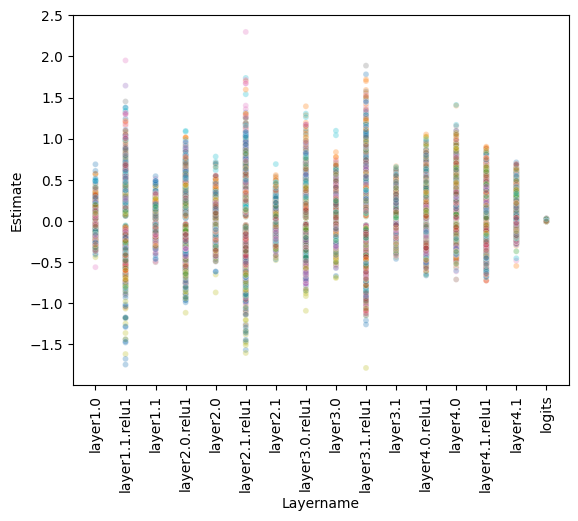

In [37]:
# plot the coefficients as scatter over layers
p = sns.scatterplot(data=significant_estimates, x="Layername", y="Estimate", hue="Class", alpha=0.3, size=0.1)
p.set_xticklabels(p.get_xticklabels(), rotation=90)
p.legend_.remove()
p

/tmp/ipykernel_13689/4100653100.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator


<Axes: xlabel='Layername', ylabel='Estimate'>

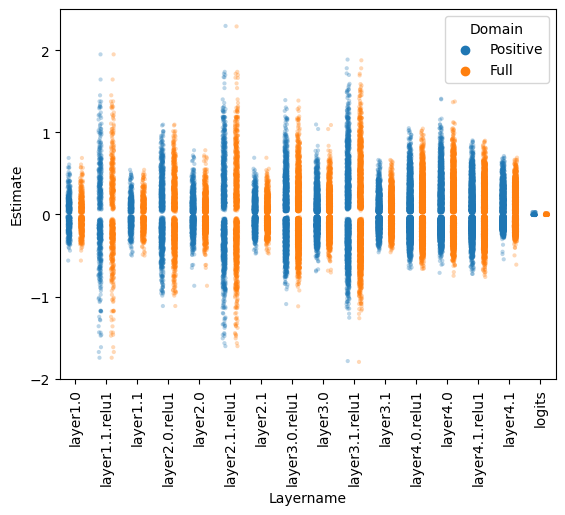

In [38]:
# compare the full and pos. coeffs
# Not much difference, which makes sense

est_regression_df_pos_acts_class_logits['Domain'] = 'Positive'
est_regression_df_full_acts_class_logits['Domain'] = 'Full'
joined_df = pd.concat([est_regression_df_pos_acts_class_logits, est_regression_df_full_acts_class_logits])
significant_estimates_joined = joined_df[joined_df["Estimate significant (alpha=0.05)"]]

p = sns.stripplot(data=significant_estimates_joined, x="Layername", y="Estimate", hue="Domain", dodge=True, jitter=True, alpha=0.3, size=3)
p.set_xticklabels(p.get_xticklabels(), rotation=90)
p

In [19]:
# Correlation? Super high.
np.corrcoef(est_regression_df_pos_acts_class_logits["Estimate"], est_regression_df_full_acts_class_logits["Estimate"])

array([[1.        , 0.99811981],
       [0.99811981, 1.        ]])

### Plot neuron with low coeff.

In [40]:
significant_estimates.loc[significant_estimates["Estimate"] < -1.75]

Unnamed: 0  Layer       Layername  Neuron Class  Estimate   
12778       12778      9  layer3.1.relu1      61     8 -1.786071  \

       Estimate Std.  Estimate pvalue  Estimate significant (alpha=0.05)   
12778       0.054478    5.384616e-224                               True  \

       Intercept  Intercept Std.  Intercept pvalue   
12778   0.273552        0.005989               0.0  \

       Intercept significant (alpha=0.05)  R-squared  
12778                                True   0.097168

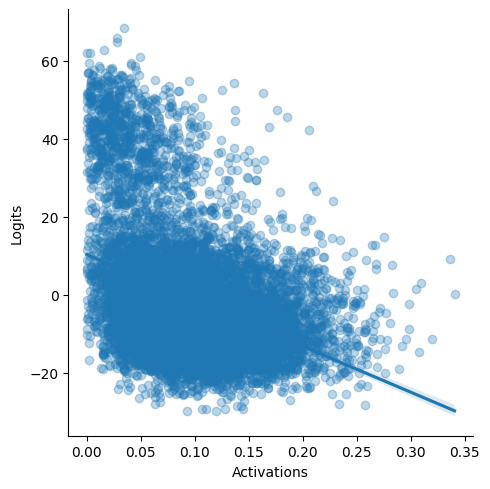

In [41]:
layeri, neuroni, classi = 9, 61, 8
df_neuron = produce_df_class_logits(activations_dict, layers, logits, layeri, neuroni, classi)
df_neuron = df_neuron.loc[df_neuron['Activations'] >= 0] 
sns.lmplot(data=df_neuron, x='Activations', y='Logits', scatter_kws={"alpha":0.3})
# df_neuron['Logits']

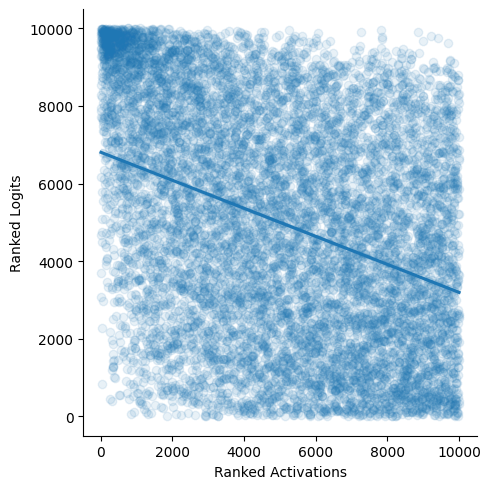

In [48]:
#DONE: rank plot
df_neuron["Ranked Activations"] = df_neuron["Activations"].rank()
df_neuron["Ranked Logits"] = df_neuron["Logits"].rank()
sns.lmplot(data=df_neuron, x='Ranked Activations', y='Ranked Logits', scatter_kws={"alpha":0.1})
# sns.scatterplot(data=df_neuron, x='Ranked Activations', y='Ranked Logits', alpha=0.1)

In [20]:
# Irrelevant, because not useful

# # compare true and predicted labels
# # smaller spread for predicted... less noisy makes sense

# est_regression_df_pos_acts_class_true['Labels'] = 'True'
# est_regression_df_pos_acts_class_predicted['Labels'] = 'Predicted'
# joined_df = pd.concat([est_regression_df_pos_acts_class_true, est_regression_df_pos_acts_class_predicted])
# significant_estimates_joined = joined_df[joined_df["Estimate significant (alpha=0.05)"]]

# p = sns.stripplot(data=significant_estimates_joined, x="Layername", y="Estimate", hue="Labels", dodge=True, jitter=True, alpha=0.3, size=3)
# p.set_xticklabels(p.get_xticklabels(), rotation=30)
# p

## Maximum predicted class

/tmp/ipykernel_13689/2422117746.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator


<Axes: xlabel='Layername', ylabel='Estimate'>

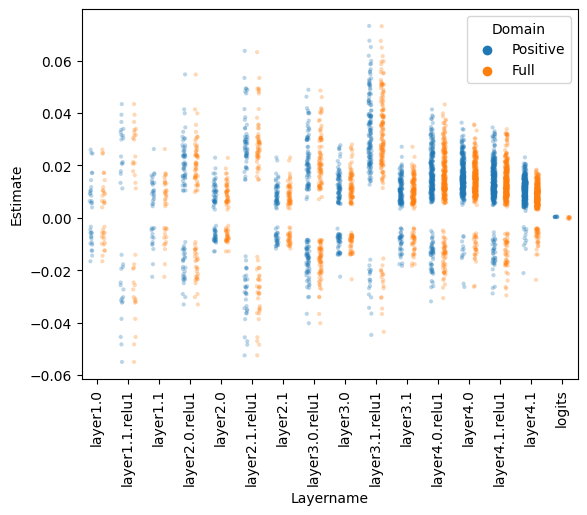

In [21]:
# compare true and predicted labels
# smaller spread for predicted... less noisy makes sense

est_regression_df_pos_acts_max_class['Domain'] = "Positive"
est_regression_df_full_acts_max_class['Domain'] = "Full"
joined_df = pd.concat([est_regression_df_pos_acts_max_class, est_regression_df_full_acts_max_class])
significant_estimates = joined_df[joined_df["Estimate significant (alpha=0.05)"]]

p = sns.stripplot(data=significant_estimates, x="Layername", y="Estimate", hue='Domain', alpha=0.3, size=3, dodge=True, jitter=True)
p.set_xticklabels(p.get_xticklabels(), rotation=90)
p

### How many are significant?

In [22]:
joined_df["Estimate significant (alpha=0.05)"].sum()/len(joined_df)

0.626122556788167

In [23]:
# numbers per layer that are above or below zero
significant_estimates["Estimate < 0"] = significant_estimates["Estimate"] < 0
significant_estimates["Estimate >= 0"] = significant_estimates["Estimate"] > 0
counts_negative_coeff_df = pd.DataFrame(significant_estimates.groupby("Layername")["Estimate < 0"].sum())
counts_positive_coeff_df = pd.DataFrame(significant_estimates.groupby("Layername")["Estimate >= 0"].sum())
counts_negative_coeff_df = counts_negative_coeff_df.rename(columns={"Estimate < 0": "Counts"})
counts_negative_coeff_df["Type"] = "Estimate < 0"
counts_positive_coeff_df = counts_positive_coeff_df.rename(columns={"Estimate >= 0": "Counts"})
counts_positive_coeff_df["Type"] = "Estimate >= 0"

counts_df = pd.concat([counts_negative_coeff_df, counts_positive_coeff_df]).reset_index()
counts_df

/tmp/ipykernel_13689/82020269.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_13689/82020269.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Layername  Counts           Type
0         layer1.0      30   Estimate < 0
1         layer1.1      26   Estimate < 0
2   layer1.1.relu1      32   Estimate < 0
3         layer2.0      56   Estimate < 0
4   layer2.0.relu1      56   Estimate < 0
5         layer2.1      52   Estimate < 0
6   layer2.1.relu1      60   Estimate < 0
7         layer3.0      77   Estimate < 0
8   layer3.0.relu1     124   Estimate < 0
9         layer3.1      68   Estimate < 0
10  layer3.1.relu1      34   Estimate < 0
11        layer4.0      39   Estimate < 0
12  layer4.0.relu1      98   Estimate < 0
13        layer4.1      44   Estimate < 0
14  layer4.1.relu1      78   Estimate < 0
15          logits       4   Estimate < 0
16        layer1.0      34  Estimate >= 0
17        layer1.1      44  Estimate >= 0
18  layer1.1.relu1      36  Estimate >= 0
19        layer2.0      82  Estimate >= 0
20  layer2.0.relu1     100  Estimate >= 0
21        layer2.1      96  Estimate >= 0
22  layer2.1.relu1     104  Estimate >= 0
23        layer3.0     148  Estimate >= 0
24  layer3.0.relu1     155  Estimate >= 0
25        layer3.1     240  Estimate >= 0
26  layer3.1.relu1     259  Estimate >= 0
27        layer4.0     603  Estimate >= 0
28  layer4.0.relu1     474  Estimate >= 0
29        layer4.1     768  Estimate >= 0
30  layer4.1.relu1     707  Estimate >= 0
31          logits      13  Estimate >= 0

<Axes: xlabel='Layername', ylabel='Counts'>

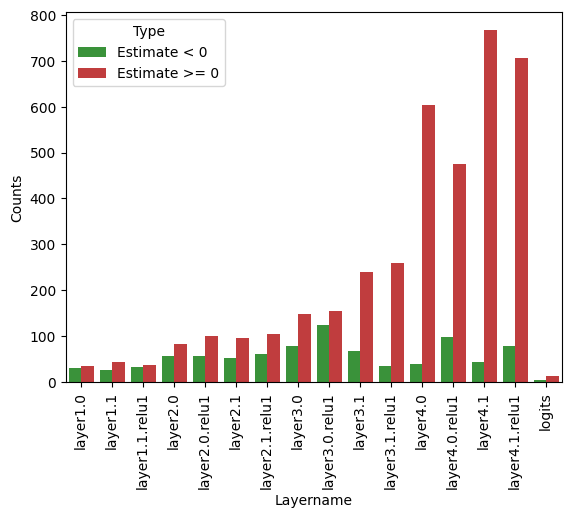

In [24]:
palette = {"Estimate < 0": "C2", "Estimate >= 0": "C3"}

p = sns.barplot(data=counts_df, x="Layername", y="Counts", hue="Type", palette=palette)
p.set_xticklabels(p.get_xticklabels(), rotation=90)
p

Fewer inhibitory neurons, especially for later layers. But, earlier layers could just fit worse with lin. regression.

/tmp/ipykernel_13689/3268625740.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_13689/3268625740.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator


<Axes: xlabel='Layername', ylabel='R-squared'>

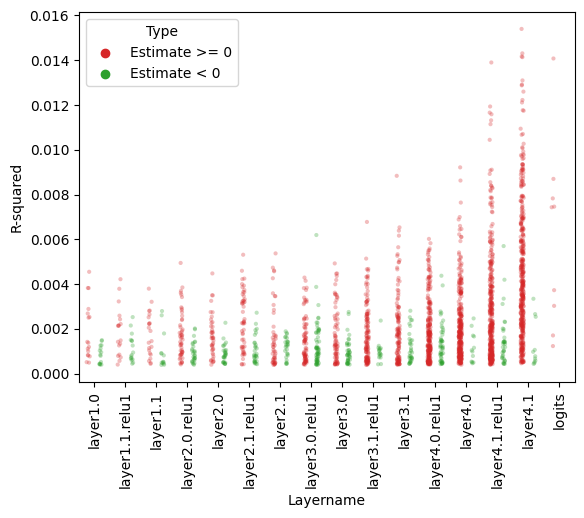

In [25]:
df = significant_estimates.loc[significant_estimates["Domain"] == "Positive"]
df["Type"] = df["Estimate < 0"].apply(lambda x: "Estimate < 0" if x else "Estimate >= 0")

palette = {"Estimate < 0": "C2", "Estimate >= 0": "C3"}

p = sns.stripplot(data=df, x="Layername", y="R-squared", hue='Type', alpha=0.3, size=3, dodge=True, jitter=True, palette=palette)
p.set_xticklabels(p.get_xticklabels(), rotation=90)
p

Yep, the linear regression is worse for earlier layers and worse for negative estimates.

### Plot a neuron with a low coeff.

In [30]:
significant_estimates.loc[significant_estimates["Estimate"] < -0.05]

Unnamed: 0  Layer       Layername  Neuron  Estimate  Estimate Std.   
125         125      1  layer1.1.relu1      61 -0.055010       0.011866  \
548         548      5  layer2.1.relu1     100 -0.052515       0.010061   
125         125      1  layer1.1.relu1      61 -0.055010       0.011866   
548         548      5  layer2.1.relu1     100 -0.052515       0.010061   

     Estimate pvalue  Estimate significant (alpha=0.05)  Intercept   
125     3.596437e-06                               True   0.991496  \
548     1.829348e-07                               True   0.991017   
125     3.596437e-06                               True   0.991496   
548     1.829348e-07                               True   0.991017   

     Intercept Std.  Intercept pvalue  Intercept significant (alpha=0.05)   
125        0.001774               0.0                                True  \
548        0.001524               0.0                                True   
125        0.001774               0.0                                True   
548        0.001524               0.0                                True   

     R-squared    Domain  Estimate < 0  Estimate >= 0  
125   0.002145  Positive          True          False  
548   0.002718  Positive          True          False  
125   0.002145      Full          True          False  
548   0.002718      Full          True          False

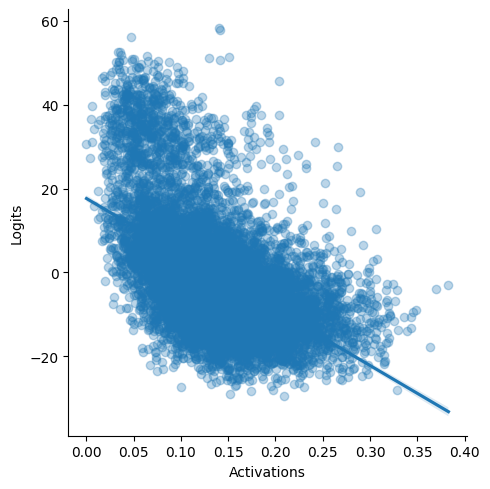

In [33]:
layeri, neuroni = 1, 61
df_neuron = produce_df_max_class(activations_dict, layers, logits, layeri, neuroni)
df_neuron = df_neuron.loc[df_neuron['Activations'] >= 0] 
sns.lmplot(data=df_neuron, x='Activations', y='Logits', scatter_kws={"alpha":0.3})
# df_neuron['Logits']

# Solved: What about the intercepts? Ignore them.

If they are already quite high, then a coeff. of zero still means that the class is predicted..

But I still think it should be ignored. We care about: the bigger, the better?

# Feature relevance experiments by Reimers

Partial correlation of activations with class logits conditioned on the class. 

In [157]:
fr_type = "pcorr"

if fr_type == "pcorr":
    on_name = "Logits".replace(".", "")
    
    # (linear) partial correlation
    est_fr_pos = pd.read_csv(f"local_storage/cifar10_pcorr_{on_name}_estimates_pos_afterrelu.csv")
    est_fr_full = pd.read_csv(f"local_storage/cifar10_pcorr_{on_name}_estimates_full_afterrelu.csv")
elif fr_type == "RCOT":
    print("RCOT is always positive. There is no directional information in nonlinear correlation.")

    # (nonlinear) RCOT
    est_fr_pos = pd.read_csv("local_storage/cifar10_rcot_estimates_pos_afterrelu.csv")
    est_fr_full = pd.read_csv("local_storage/cifar10_rcot_estimates_full_afterrelu.csv")
else:
    raise Exception(f"Invalid fr_type: {fr_type}")

In [158]:
significant_est_fr_pos = est_fr_pos.loc[est_fr_pos["Estimate significant (alpha=0.05)"]]
significant_est_fr_full = est_fr_full.loc[est_fr_full["Estimate significant (alpha=0.05)"]]

In [159]:
significant_est_fr_pos["Class"] = pd.Categorical(significant_est_fr_pos["Class"])
significant_est_fr_full["Class"] = pd.Categorical(significant_est_fr_full["Class"])

/tmp/ipykernel_21683/3205970414.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_21683/3205970414.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/tmp/ipykernel_21683/3273398443.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator


<Axes: xlabel='Layername', ylabel='Estimate'>

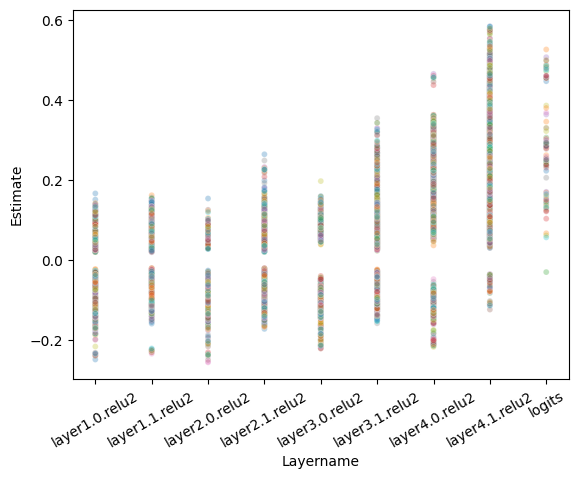

In [160]:
p = sns.scatterplot(data=significant_est_fr_pos, x="Layername", y="Estimate", hue="Class", alpha=0.3, size=0.1)
p.set_xticklabels(p.get_xticklabels(), rotation=30)
p.legend_.remove()
p

In [162]:
significant_est_fr_pos['Domain'] = "after ReLU"
significant_est_fr_full['Domain'] = "pre ReLU"
significant_est_fr_both = pd.concat([significant_est_fr_pos, significant_est_fr_full])

/tmp/ipykernel_21683/221518593.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_21683/221518593.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/tmp/ipykernel_21683/2351503340.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator


<Axes: xlabel='Layername', ylabel='Estimate'>

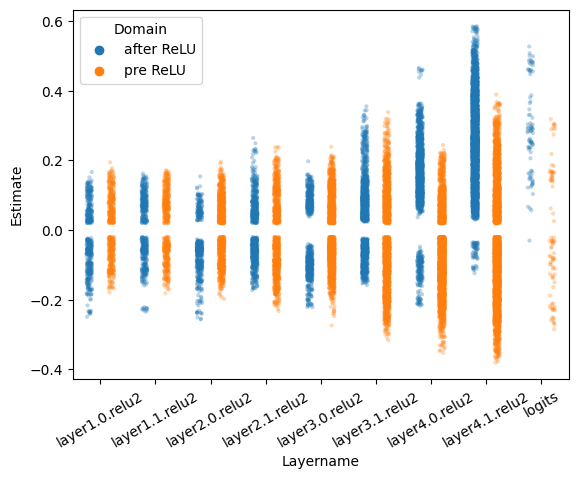

In [163]:
p = sns.stripplot(data=significant_est_fr_both, x="Layername", y="Estimate", hue="Domain", dodge=True, jitter=True, alpha=0.3, size=3)
p.set_xticklabels(p.get_xticklabels(), rotation=30)
p

/tmp/ipykernel_21683/3301451731.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator


<Axes: xlabel='Layername', ylabel='Estimate (abs.)'>

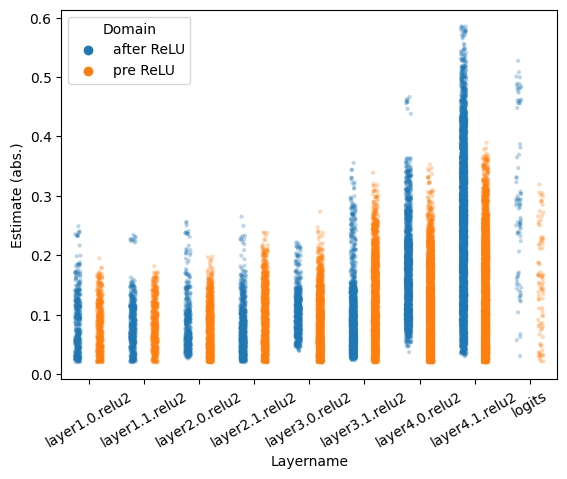

In [164]:
significant_est_fr_both["Estimate (abs.)"] = significant_est_fr_both["Estimate"].abs()
p = sns.stripplot(data=significant_est_fr_both, x="Layername", y="Estimate (abs.)", hue="Domain", dodge=True, jitter=True, alpha=0.3, size=3)
p.set_xticklabels(p.get_xticklabels(), rotation=30)
p

## Inspect a single neuron-class combination

In [79]:
df_class_fr = produce_df_class_feature_relevance(activations_dict, layers, labels, logits, 7, 464, 2, softmax_temperature=0.1)
df_class_fr
est_pcorr(df_class_fr)

{'Estimate': 0.105754236901567,
 'Estimate pvalue': 2.892308167869937e-26,
 'Estimate significant (alpha=0.05)': True}

In [80]:
df_class_fr["Class Int"] = df_class_fr["Classes"].apply(np.argmax)

In [81]:
df_class_fr

Probs.     Logits  Logits max.  Activations     Classes   
0     0.436204  19.565910    19.565910     0.049042  [1.0, 0.0]  \
1     0.366665  23.999838    23.999838    -0.345407  [1.0, 0.0]   
2     0.590924  28.622532    28.622532    -0.694339  [1.0, 0.0]   
3     0.976641  54.541245    54.541245    -0.711505  [1.0, 0.0]   
4     0.366799  19.526831    19.526831    -0.169057  [1.0, 0.0]   
...        ...        ...          ...          ...         ...   
9995  0.835544  13.112501    13.112501     0.091364  [0.0, 1.0]   
9996  0.931800  24.931564    24.931564     0.008196  [0.0, 1.0]   
9997  0.957247  14.933183    19.621107    -0.154476  [0.0, 1.0]   
9998  0.999951  67.794579    67.794579     2.426380  [0.0, 1.0]   
9999  0.978060  25.623310    25.623310     0.843837  [0.0, 1.0]   

               Domain  Class Int  
0     Above threshold          0  
1     Below threshold          0  
2     Below threshold          0  
3     Below threshold          0  
4     Below threshold          0  
...               ...        ...  
9995  Above threshold          1  
9996  Above threshold          1  
9997  Below threshold          1  
9998  Above threshold          1  
9999  Above threshold          1  

[10000 rows x 7 columns]

<Axes: xlabel='Activations', ylabel='Logits'>

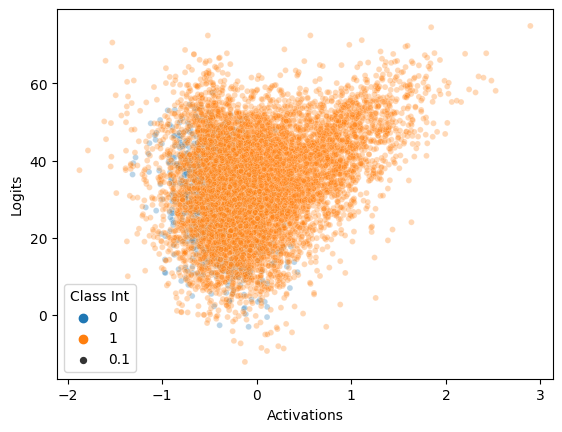

In [82]:
# sns.scatterplot(data=df_class_fr, x="Activations", y="Probs.", hue="Class Int")
sns.scatterplot(data=df_class_fr, x="Activations", y="Logits", hue="Class Int", alpha=0.3, size=0.1)

## Double check pcorr

In [117]:
# standardize
from scipy import stats
df_class_fr["Activations (standardized)"] = stats.zscore(df_class_fr["Activations"])
df_class_fr["Logits (standardized)"] = stats.zscore(df_class_fr["Logits"])
df_class_fr["Probs. (standardized)"] = stats.zscore(df_class_fr["Probs."])

In [148]:
from sklearn.linear_model import LinearRegression

df_in_class = df_class_fr.loc[df_class_fr["Class Int"] == 0]
df_out_class = df_class_fr.loc[df_class_fr["Class Int"] == 1]

X_name = "Activations"
Y_name = "Logits"
# Y_name = "Probs. (standardized)"
Z_name = "Class Int"

# This is the same as pcorr from tigramite

res_x_in = df_in_class[X_name] - df_in_class[X_name].mean()
res_x_out = df_out_class[X_name] - df_out_class[X_name].mean()
res_x = pd.concat([res_x_in, res_x_out])
res_y_in = df_in_class[Y_name] - df_in_class[Y_name].mean()
res_y_out = df_out_class[Y_name] - df_out_class[Y_name].mean()
res_y = pd.concat([res_y_in, res_y_out])

np.corrcoef(res_x, res_y)

In [ ]:
ds =  []
for _ in range(30):
    X = np.random.randn(1000)
    ds.append(rcot(X, 10*X, np.random.randn(1000), approx="hbe")[-1])
(np.array(ds) > 0).sum()/len(ds)

This could be a problem. If this reasoning here is more valid that looking at the shifts, then one should have looked at this from the get go.

## Load (wasserstein) shifts for bettercifar10

I guess I have shift for more layers than what I've just computed.

In [62]:
def load_wasser_shifts_into_dataframe(layeri, layername):
    shift_dict = np.load(f"wasser_dists/wasser_shift_attr_hist_bettercifar10single_{layeri}.npy", allow_pickle=True).item()

    flat_dicts = []
    for key in sorted(shift_dict.keys()):
        class_dict = shift_dict[key]
        assert sorted(class_dict.keys()) == list(range(10))
        for classi in sorted(class_dict.keys()):
            shift = class_dict[classi]
            fd = {"Layername": layername, "Neuron": key, "Class": classi, "Shift": shift}
            flat_dicts.append(fd)

    return pd.DataFrame(flat_dicts)

In [63]:
load_wasser_shifts_into_dataframe(0, "layer1.0")

Layername  Neuron  Class     Shift
0    layer1.0       0      0  0.442388
1    layer1.0       0      1 -0.034991
2    layer1.0       0      2 -0.064777
3    layer1.0       0      3  0.006369
4    layer1.0       0      4 -0.190851
..        ...     ...    ...       ...
635  layer1.0      63      5 -0.000245
636  layer1.0      63      6 -0.020991
637  layer1.0      63      7 -0.008392
638  layer1.0      63      8  0.008768
639  layer1.0      63      9 -0.001551

[640 rows x 4 columns]

In [66]:
all_layerdfs = []
for li, ln in enumerate(layers_bn_afterrelu):
    all_layerdfs.append(load_wasser_shifts_into_dataframe(li, ln))

shifts_df = pd.concat(all_layerdfs)
shifts_df

Layername  Neuron  Class     Shift
0     layer1_0       0      0  0.442388
1     layer1_0       0      1 -0.034991
2     layer1_0       0      2 -0.064777
3     layer1_0       0      3  0.006369
4     layer1_0       0      4 -0.190851
...        ...     ...    ...       ...
5115  layer4_1     511      5 -0.277306
5116  layer4_1     511      6 -0.101675
5117  layer4_1     511      7 -0.296050
5118  layer4_1     511      8 -0.091661
5119  layer4_1     511      9  0.416410

[37760 rows x 4 columns]

In [67]:
# Not necessary, when afterrelu layers are used

# #DONE: get the map from layeri to layername
# map_between_layernames = lambda prerelu: ".".join(prerelu.split(".")[:-1])
# find_layeri_from_mapped_layername = lambda afterrelu_mapped: layers_bn_afterrelu.index(afterrelu_mapped.replace(".", "_"))

# valid_layernames = [map_between_layernames(ln) for ln in significant_est_fr_both["Layername"].unique().tolist() if 'logits' not in ln]

# all_layerdfs = []
# for valid_ln in valid_layernames:
#     all_layerdfs.append(load_wasser_shifts_into_dataframe(find_layeri_from_mapped_layername(valid_ln), valid_ln))

# shifts_df = pd.concat(all_layerdfs)
# assert len(shifts_df) == len(est_fr_pos.loc[est_fr_pos['Layername'] != "logits"])

/tmp/ipykernel_21683/2501654265.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator


<Axes: xlabel='Layername', ylabel='Shift'>

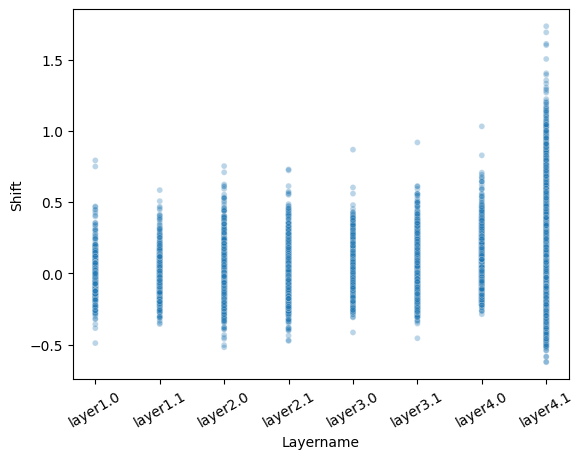

In [187]:
p = sns.scatterplot(data=shifts_df, x="Layername", y="Shift", alpha=0.3, size=0.1)
p.set_xticklabels(p.get_xticklabels(), rotation=30)
p.legend_.remove()
p

In [188]:
# DONE: merge the two dataframes and correlate
significant_est_fr_pos_valid_layers = significant_est_fr_pos.loc[significant_est_fr_pos["Layername"] != "logits"]
significant_est_fr_pos_valid_layers["Mapped Layername"] = significant_est_fr_pos_valid_layers["Layername"].map(map_between_layernames)
significant_est_fr_pos_valid_layers["Mapped Layername"]

/tmp/ipykernel_21683/3737564202.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0        layer1.0
1        layer1.0
8        layer1.0
10       layer1.0
11       layer1.0
           ...   
19195    layer4.1
19196    layer4.1
19197    layer4.1
19198    layer4.1
19199    layer4.1
Name: Mapped Layername, Length: 12028, dtype: object

In [189]:
merged_df = pd.merge(significant_est_fr_pos_valid_layers, shifts_df,  how='left', left_on=['Mapped Layername','Neuron', 'Class'], right_on = ['Layername','Neuron', 'Class'])

merged_df[['Estimate', 'Shift']].corr()

merged_df_neg_shifts = merged_df.loc[merged_df['Shift'] < 0]
merged_df_pos_shifts = merged_df.loc[merged_df['Shift'] >= 0]

merged_df_neg_shifts[['Estimate', 'Shift']].corr(), merged_df_pos_shifts[['Estimate', 'Shift']].corr()

(          Estimate     Shift
 Estimate  1.000000 -0.424234
 Shift    -0.424234  1.000000,
           Estimate     Shift
 Estimate  1.000000  0.472534
 Shift     0.472534  1.000000)

/tmp/ipykernel_21683/1049213218.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_21683/1049213218.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator


<Axes: xlabel='Mapped Layername', ylabel='Estimate'>

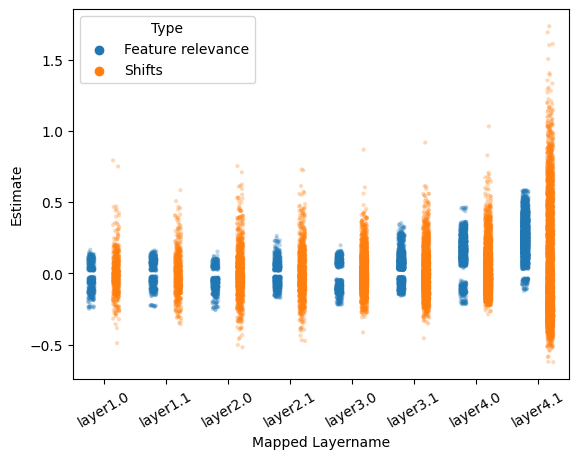

In [191]:
#TODO: draw lines to connect points

significant_est_fr_pos_valid_layers["Type"] = "Feature relevance"
shifts_df["Type"] = "Shifts"
shifts_df["Estimate"] = shifts_df["Shift"]
shifts_df["Mapped Layername"] = shifts_df["Layername"]

stacked_df = pd.concat([significant_est_fr_pos_valid_layers, shifts_df])

p = sns.stripplot(data=stacked_df, x="Mapped Layername", y="Estimate", hue="Type", dodge=True, jitter=True, alpha=0.3, size=3)
p.set_xticklabels(p.get_xticklabels(), rotation=30)
p

In [181]:
significant_est_fr_pos_valid_layers["Mapped Layername"]

KeyError: 'Mapped Layername'

Okay, shifts and feature relevance don't correlate. It's not entirely clear which is more valid. Probably shifts. BUT double-check with the linear regressions of activations to logits.

### Feature relevance vs. lin. regressions

In [176]:
significant_est_fr_pos_valid_layers = significant_est_fr_pos.loc[significant_est_fr_pos["Layername"] != "logits"]

merged_df = pd.merge(significant_est_fr_pos_valid_layers, significant_estimates,  how='left', left_on=['Layername','Neuron', 'Class'], right_on = ['Layername','Neuron', 'Class'])
merged_df[["Estimate_x", "Estimate_y"]].corr()

Estimate_x  Estimate_y
Estimate_x    1.000000   -0.051751
Estimate_y   -0.051751    1.000000

In [46]:
merged_df_neg_rel = merged_df.loc[merged_df['Estimate_x'] < 0]
merged_df_pos_rel = merged_df.loc[merged_df['Estimate_x'] >= 0]

merged_df_neg_reg = merged_df.loc[merged_df['Estimate_y'] < 0]
merged_df_pos_reg = merged_df.loc[merged_df['Estimate_y'] >= 0]

merged_df_neg_rel[['Estimate_x', 'Estimate_y']].corr(), merged_df_pos_rel[['Estimate_x', 'Estimate_y']].corr(), merged_df_neg_reg[['Estimate_x', 'Estimate_y']].corr(), merged_df_pos_reg[['Estimate_x', 'Estimate_y']].corr()

(            Estimate_x  Estimate_y
 Estimate_x    1.000000    0.530855
 Estimate_y    0.530855    1.000000,
             Estimate_x  Estimate_y
 Estimate_x    1.000000   -0.054085
 Estimate_y   -0.054085    1.000000,
             Estimate_x  Estimate_y
 Estimate_x    1.000000   -0.342517
 Estimate_y   -0.342517    1.000000,
             Estimate_x  Estimate_y
 Estimate_x    1.000000   -0.011767
 Estimate_y   -0.011767    1.000000)

### Lin. regression vs. shifts

In [177]:
# DONE: merge the two dataframes and correlate
significant_estimates_valid_layers = significant_estimates.loc[significant_estimates["Layername"] != "logits"]
significant_estimates_valid_layers["Mapped Layername"] = significant_estimates_valid_layers["Layername"].map(map_between_layernames)
significant_estimates_valid_layers["Mapped Layername"]

/tmp/ipykernel_21683/2502995904.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0        layer1.0
4        layer1.0
6        layer1.0
7        layer1.0
8        layer1.0
           ...   
19188    layer4.1
19190    layer4.1
19192    layer4.1
19196    layer4.1
19199    layer4.1
Name: Mapped Layername, Length: 4333, dtype: object

In [178]:
merged_df = pd.merge(significant_estimates_valid_layers, shifts_df,  how='left', left_on=['Mapped Layername','Neuron', 'Class'], right_on = ['Layername','Neuron', 'Class'])

merged_df_neg_shifts = merged_df.loc[merged_df['Shift'] < 0]
merged_df_pos_shifts = merged_df.loc[merged_df['Shift'] >= 0]

merged_df[['Estimate', 'Shift']].corr(), merged_df_neg_shifts[['Estimate', 'Shift']].corr(), merged_df_pos_shifts[['Estimate', 'Shift']].corr()

(          Estimate     Shift
 Estimate  1.000000  0.340976
 Shift     0.340976  1.000000,
           Estimate     Shift
 Estimate  1.000000  0.120189
 Shift     0.120189  1.000000,
           Estimate     Shift
 Estimate  1.000000  0.186874
 Shift     0.186874  1.000000)

# Compare stuff with Jacobians

In [53]:
jacs_df = pd.read_pickle(f"{LOCAL_STORAGE}/grads_val_bettercifar10single_afterrelu_all_samples.pkl")

# rearrange to one long list and rename columns
jacs_df["Layername"] = jacs_df["layer_name"].map(lambda ln: ln.replace(".", "_"))
jacs_df["Neuron"] = jacs_df["neuron_idx"]
jacs_df = jacs_df[["Layername", "Neuron", 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
jacs_df = jacs_df.melt(id_vars=["Layername", "Neuron"], var_name="Class", value_name="Jacobian")
jacs_df["Layeri"] = jacs_df["Layername"].map(lambda ln: layers_bn_afterrelu.index(ln))
jacs_df = jacs_df.sort_values(by=["Layeri", "Neuron"], ignore_index=True)


### Compare with jacobians that are computed only within class

In [59]:
#DONE: compare old and new jacs: SIMILAR
jacs_df_only_class = pd.read_pickle(f"{LOCAL_STORAGE}/grads_val_bettercifar10single_afterrelu.pkl")

# rearrange to one long list and rename columns
jacs_df_only_class["Layername"] = jacs_df_only_class["layer_name"].map(lambda ln: ln.replace(".", "_"))
jacs_df_only_class["Neuron"] = jacs_df_only_class["neuron_idx"]
jacs_df_only_class = jacs_df_only_class[["Layername", "Neuron", 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
jacs_df_only_class = jacs_df_only_class.melt(id_vars=["Layername", "Neuron"], var_name="Class", value_name="Jacobian")
jacs_df_only_class["Layeri"] = jacs_df_only_class["Layername"].map(lambda ln: layers_bn_afterrelu.index(ln))
jacs_df_only_class = jacs_df_only_class.sort_values(by=["Layeri", "Neuron"], ignore_index=True)
jacs_df_only_class = jacs_df_only_class.rename(columns={"Jacobian":"Jacobian (only in class)"})

In [61]:
merged_df = pd.merge(jacs_df, jacs_df_only_class,  how='left', left_on=['Layername','Neuron', 'Class'], right_on = ['Layername','Neuron', 'Class'])

merged_df[['Jacobian', 'Jacobian (only in class)']].corr()

Jacobian  Jacobian (only in class)
0      0.000649                  0.000613
1      0.000185                  0.000220
2     -0.000765                 -0.000698
3      0.000072                  0.000040
4     -0.000185                 -0.000242
...         ...                       ...
37755 -0.019719                 -0.019719
37756 -0.005411                 -0.005411
37757 -0.017388                 -0.017388
37758  0.006872                  0.006872
37759  0.015701                  0.015701

[37760 rows x 2 columns]

## Compare with shifts

In [68]:
merged_df = pd.merge(jacs_df, shifts_df,  how='left', left_on=['Layername','Neuron', 'Class'], right_on = ['Layername','Neuron', 'Class'])

merged_df_neg_shifts = merged_df.loc[merged_df['Shift'] < 0]
merged_df_pos_shifts = merged_df.loc[merged_df['Shift'] >= 0]

merged_df[['Jacobian', 'Shift']].corr(), merged_df_neg_shifts[['Jacobian', 'Shift']].corr(), merged_df_pos_shifts[['Jacobian', 'Shift']].corr()

(          Jacobian     Shift
 Jacobian  1.000000  0.555255
 Shift     0.555255  1.000000,
           Jacobian     Shift
 Jacobian  1.000000  0.396899
 Shift     0.396899  1.000000,
           Jacobian     Shift
 Jacobian  1.000000  0.429515
 Shift     0.429515  1.000000)

In [85]:
grouped_merged_df = merged_df.groupby(["Layername", "Neuron"])
grouped_merged_df[['Jacobian', 'Shift']].corr().unstack().iloc[0::2]["Jacobian"][["Shift"]].rename(columns={'Shift': "Corr. Jacobian - Shift"})

Corr. Jacobian - Shift
Layername      Neuron                        
layer1_0       0                     0.773415
               2                     0.302006
               4                     0.327221
               6                     0.696197
               8                     0.814720
...                                       ...
layer4_1_relu1 502                   0.615957
               504                   0.796754
               506                   0.919830
               508                   0.364189
               510                   0.231825

[1888 rows x 1 columns]

# Computing feature relevance...

In [13]:
est_pcorr_pos = []
est_pcorr_full = []
softmax_temperature = 0.1
on = "Logits"

for layeri, layername in enumerate(layers):
    for neuroni in range(activations_dict[layername][0].shape[1]):
        for classi in range(logits.shape[1]):
            print(layeri, neuroni, classi)
            df_class_fr = produce_df_class_feature_relevance(activations_dict, layers, labels, logits, layeri, neuroni, classi, softmax_temperature=softmax_temperature)

            df_class_fr_pos = df_class_fr[df_class_fr["Activations"] >= 0]

            d_pos = {"Layer": layeri, "Layername": layername, "Neuron": neuroni, "Class": classi}
            d_pos.update(est_pcorr(df_class_fr_pos, on = "Logits"))

            d_full = {"Layer": layeri, "Layername": layername, "Neuron": neuroni, "Class": classi}
            d_full.update(est_pcorr(df_class_fr, on = "Logits"))

            est_pcorr_pos.append(d_pos)
            est_pcorr_full.append(d_full)

on_name = on.replace(".", "")
est_pcorr_pos = pd.DataFrame(est_pcorr_pos)
est_pcorr_pos.to_csv(f"local_storage/cifar10_pcorr_{on_name}_estimates_pos_afterrelu.csv")

est_pcorr_full = pd.DataFrame(est_pcorr_full)
est_pcorr_full.to_csv(f"local_storage/cifar10_pcorr_{on_name}_estimates_full_afterrelu.csv")

0 0 0
0 0 1
0 0 2
0 0 3
0 0 4
0 0 5
0 0 6
0 0 7
0 0 8
0 0 9
0 1 0
0 1 1
0 1 2
0 1 3
0 1 4
0 1 5
0 1 6
0 1 7
0 1 8
0 1 9
0 2 0
0 2 1
0 2 2
0 2 3
0 2 4
0 2 5
0 2 6
0 2 7
0 2 8
0 2 9
0 3 0
0 3 1
0 3 2
0 3 3
0 3 4
0 3 5
0 3 6
0 3 7
0 3 8
0 3 9
0 4 0
0 4 1
0 4 2
0 4 3
0 4 4
0 4 5
0 4 6
0 4 7
0 4 8
0 4 9
0 5 0
0 5 1
0 5 2
0 5 3
0 5 4
0 5 5
0 5 6
0 5 7
0 5 8
0 5 9
0 6 0
0 6 1
0 6 2
0 6 3
0 6 4
0 6 5
0 6 6
0 6 7
0 6 8
0 6 9
0 7 0
0 7 1
0 7 2
0 7 3
0 7 4
0 7 5
0 7 6
0 7 7
0 7 8
0 7 9
0 8 0
0 8 1
0 8 2
0 8 3
0 8 4
0 8 5
0 8 6
0 8 7
0 8 8
0 8 9
0 9 0
0 9 1
0 9 2
0 9 3
0 9 4
0 9 5
0 9 6
0 9 7
0 9 8
0 9 9
0 10 0
0 10 1
0 10 2
0 10 3
0 10 4
0 10 5
0 10 6
0 10 7
0 10 8
0 10 9
0 11 0
0 11 1
0 11 2
0 11 3
0 11 4
0 11 5
0 11 6
0 11 7
0 11 8
0 11 9
0 12 0
0 12 1
0 12 2
0 12 3
0 12 4
0 12 5
0 12 6
0 12 7
0 12 8
0 12 9
0 13 0
0 13 1
0 13 2
0 13 3
0 13 4
0 13 5
0 13 6
0 13 7
0 13 8
0 13 9
0 14 0
0 14 1
0 14 2
0 14 3
0 14 4
0 14 5
0 14 6
0 14 7
0 14 8
0 14 9
0 15 0
0 15 1
0 15 2
0 15 3
0 15 4
0 15 5
0 15 6
0

In [16]:
est_rcot_pos = []
est_rcot_full = []
softmax_temperature = 0.1

for layeri, layername in enumerate(layers):
    for neuroni in range(activations_dict[layername][0].shape[1]):
        for classi in range(logits.shape[1]):
            print(layeri, neuroni, classi)
            df_class_fr = produce_df_class_feature_relevance(activations_dict, layers, logits, layeri, neuroni, classi, softmax_temperature=softmax_temperature)

            df_class_fr_pos = df_class_fr[df_class_fr["Activations"] >= 0]

            d_pos = {"Layer": layeri, "Layername": layername, "Neuron": neuroni, "Class": classi}
            d_pos.update(est_rcot(df_class_fr_pos))

            d_full = {"Layer": layeri, "Layername": layername, "Neuron": neuroni, "Class": classi}
            d_full.update(est_rcot(df_class_fr))

            est_rcot_pos.append(d_pos)
            est_rcot_full.append(d_full)

est_rcot_pos = pd.DataFrame(est_rcot_pos)
est_rcot_pos.to_csv("local_storage/cifar10_rcot_estimates_pos_afterrelu.csv")

est_rcot_full = pd.DataFrame(est_rcot_full)
est_rcot_full.to_csv("local_storage/cifar10_rcot_estimates_full_afterrelu.csv")

0 0 0
0 0 1
0 0 2
0 0 3
0 0 4
0 0 5
0 0 6
0 0 7
0 0 8
0 0 9
0 1 0
Computing RCOT failed!
0 1 1
Computing RCOT failed!
0 1 2
Computing RCOT failed!
0 1 3
Computing RCOT failed!
0 1 4
Computing RCOT failed!
0 1 5
Computing RCOT failed!
0 1 6
Computing RCOT failed!
0 1 7
Computing RCOT failed!
0 1 8
Computing RCOT failed!
0 1 9
Computing RCOT failed!
0 2 0
0 2 1
0 2 2
0 2 3
0 2 4
0 2 5
0 2 6
0 2 7
0 2 8
0 2 9
0 3 0
Computing RCOT failed!
0 3 1
Computing RCOT failed!
0 3 2
Computing RCOT failed!
0 3 3
Computing RCOT failed!
0 3 4
Computing RCOT failed!
0 3 5
Computing RCOT failed!
0 3 6
Computing RCOT failed!
0 3 7
Computing RCOT failed!
0 3 8
Computing RCOT failed!
0 3 9
Computing RCOT failed!
0 4 0
0 4 1
0 4 2
0 4 3
0 4 4
0 4 5
0 4 6
0 4 7
0 4 8
0 4 9
0 5 0
0 5 1
0 5 2
0 5 3
0 5 4
0 5 5
0 5 6
0 5 7
0 5 8
0 5 9
0 6 0
0 6 1
0 6 2
0 6 3
0 6 4
0 6 5
0 6 6
0 6 7
0 6 8
0 6 9
0 7 0
0 7 1
0 7 2
0 7 3
0 7 4
0 7 5
0 7 6
0 7 7
0 7 8
0 7 9
0 8 0
0 8 1
0 8 2
0 8 3
0 8 4
0 8 5
0 8 6
0 8 7
0 8 8
0 8 9


In [86]:
df_class_fr = produce_df_class_feature_relevance(activations_dict, layers, logits, layeri, neuroni, classi, softmax_temperature=0.1)

df_class_fr = df_class_fr[df_class_fr["Activations"] >= 0]

est_pcorr(df_class_fr)

{'Estimate': -0.3521224755171544,
 'Estimate pvalue': 0.18104152771678478,
 'Estimate significant (alpha=0.05)': False}

### TODO: there is still something wrong... i can't just copy the activations.. they belong to samples of specific classes.. i should have only 10000 samples at the end

it should have: activation which belongs to a sample of a specific class. the targets are then the probabilities for the different classes. this would give relevances for the different classes..

Q: am i missing something???

In [63]:
logits.shape

(10000, 10)

In [68]:
df_all_classes["Classes"]

df_all_classes.loc[1]["Classes"] = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
df_all_classes.loc[1]["Classes"]

/tmp/ipykernel_22116/525515705.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1

# RDD experiments... I don't feel that this is sound

Most activations above 0 could be explained by extrapolating. Probably, the distribution left and right is not even enough.

## Try partial correlation of neurons given all samples, their classes and logits.

## Load dataframes, those which have the least invalid RDD estimates

In [20]:
bwselect= "msetwo"
robust_rdd_logits_df = pd.read_csv(f"local_storage/cifar10_rdd_estimates_{bwselect}_afterrelu.csv")

perc = robust_rdd_logits_df["Estimate"].notna().sum()/len(robust_rdd_logits_df["Estimate"])
print(f"Valid neuron-class combinations for {bwselect}: {perc * 100}%")

Valid neuron-class combinations for msetwo: 6.818652849740933%


/tmp/ipykernel_21242/360877066.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator


<Axes: xlabel='Layername', ylabel='Estimate'>

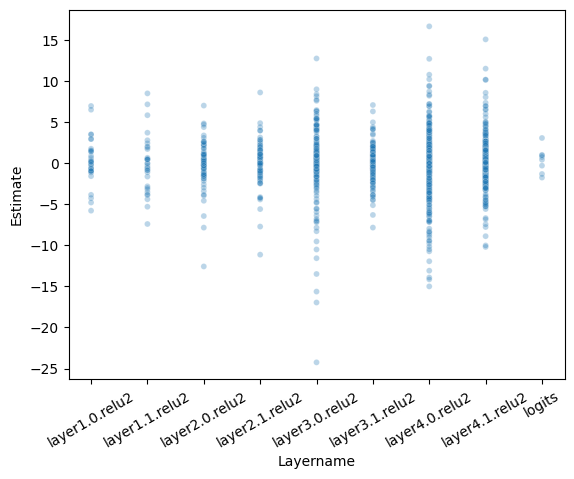

In [21]:
p = sns.scatterplot(data=robust_rdd_logits_df, x="Layername", y="Estimate", alpha=0.3, size=0.1)
p.set_xticklabels(p.get_xticklabels(), rotation=30)
p.legend_.remove()
p

## Inspect these neurons

In [27]:
robust_rdd_logits_df.loc[robust_rdd_logits_df["Estimate"] > 10]

Unnamed: 0  Layer       Layername  Neuron  Class   Estimate
4440         4440      4  layer3.0.relu2      60      0  12.722591
10015       10015      6  layer4.0.relu2     105      5  10.197374
10224       10224      6  layer4.0.relu2     126      4  12.681694
11076       11076      6  layer4.0.relu2     211      6  16.629756
11493       11493      6  layer4.0.relu2     253      3  10.747306
14647       14647      7  layer4.1.relu2      56      7  11.485663
14751       14751      7  layer4.1.relu2      67      1  10.144484
15828       15828      7  layer4.1.relu2     174      8  15.044733
18051       18051      7  layer4.1.relu2     397      1  10.125832

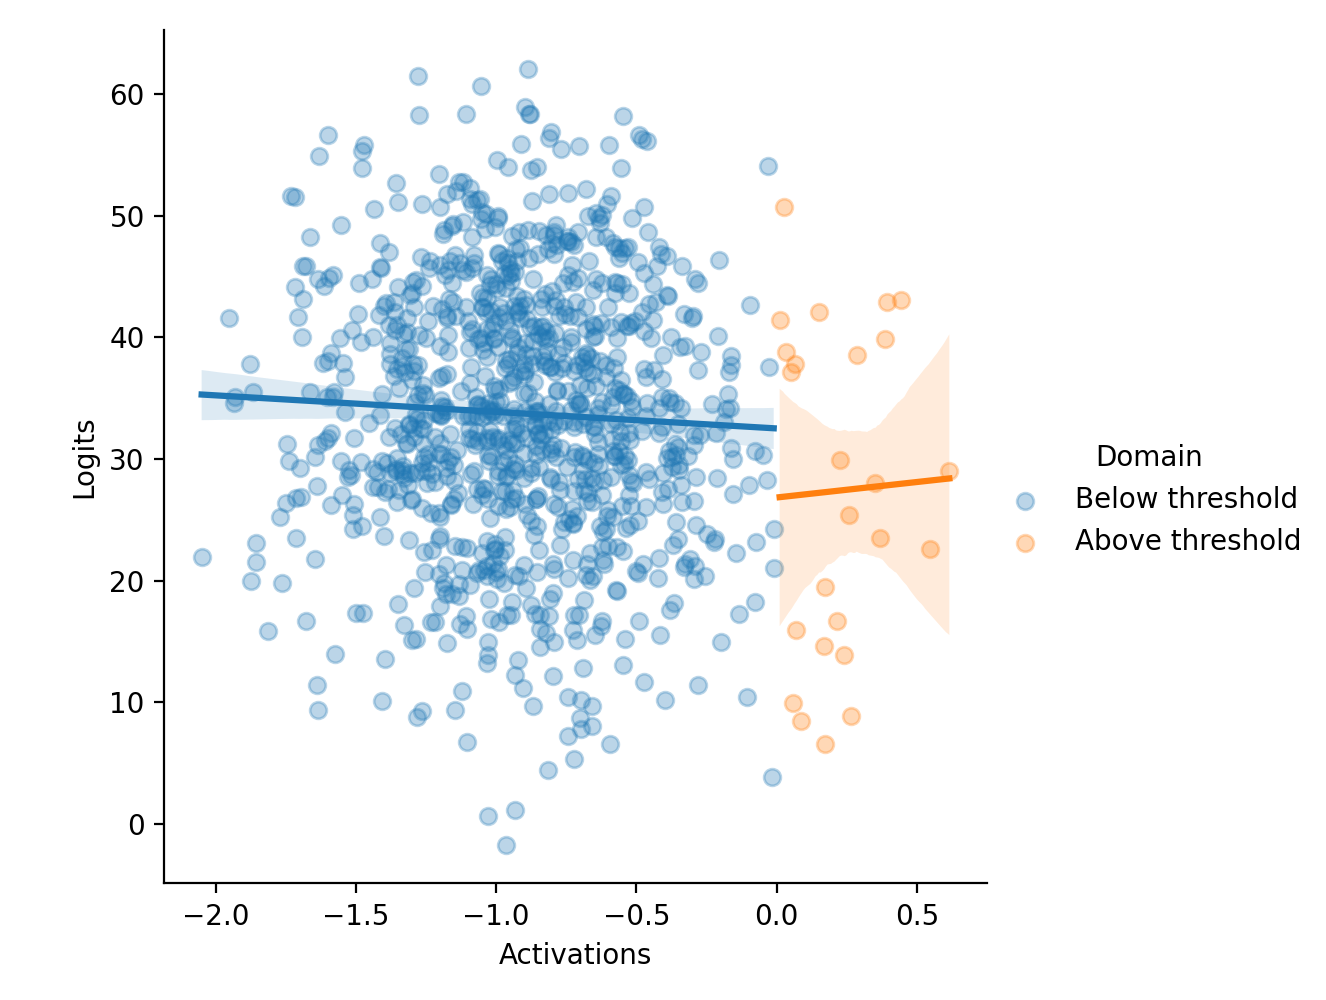

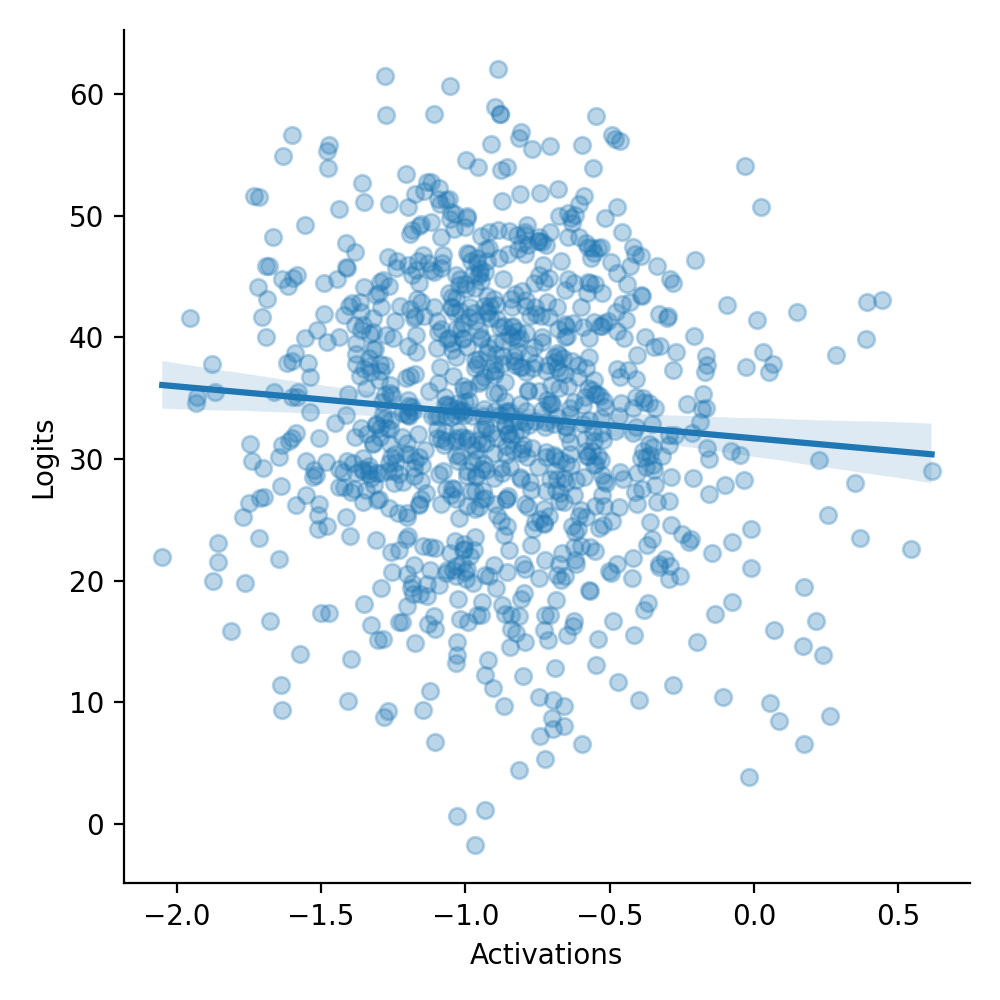

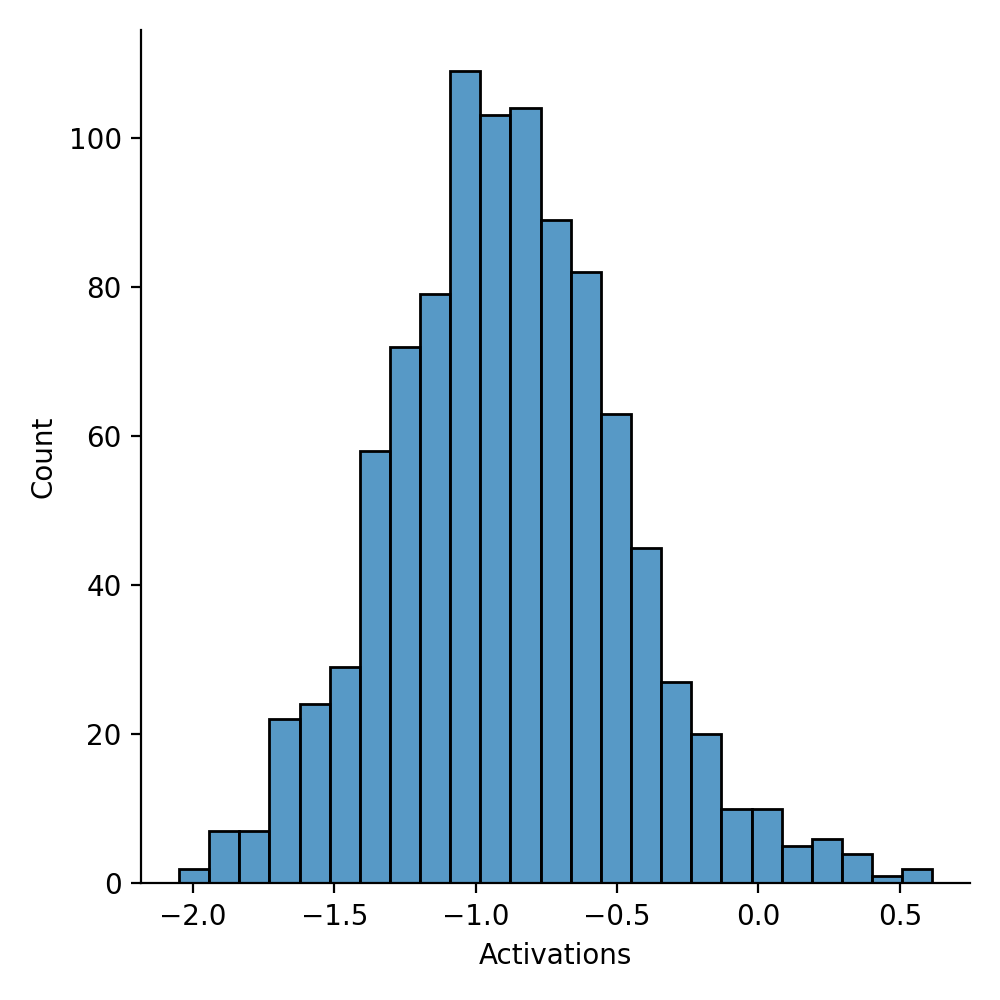

In [31]:
layeri, neuroni = 6, 211
classi = 6

df_class = produce_df_class(activations_dict, layers, labels, logits, layeri, neuroni, classi)
sns.lmplot(x = "Activations", y = "Logits", data=df_class, hue="Domain", scatter_kws={'alpha':0.3})
sns.lmplot(x = "Activations", y = "Logits", data=df_class, scatter_kws={'alpha':0.3})
sns.displot(df_class, x="Activations")

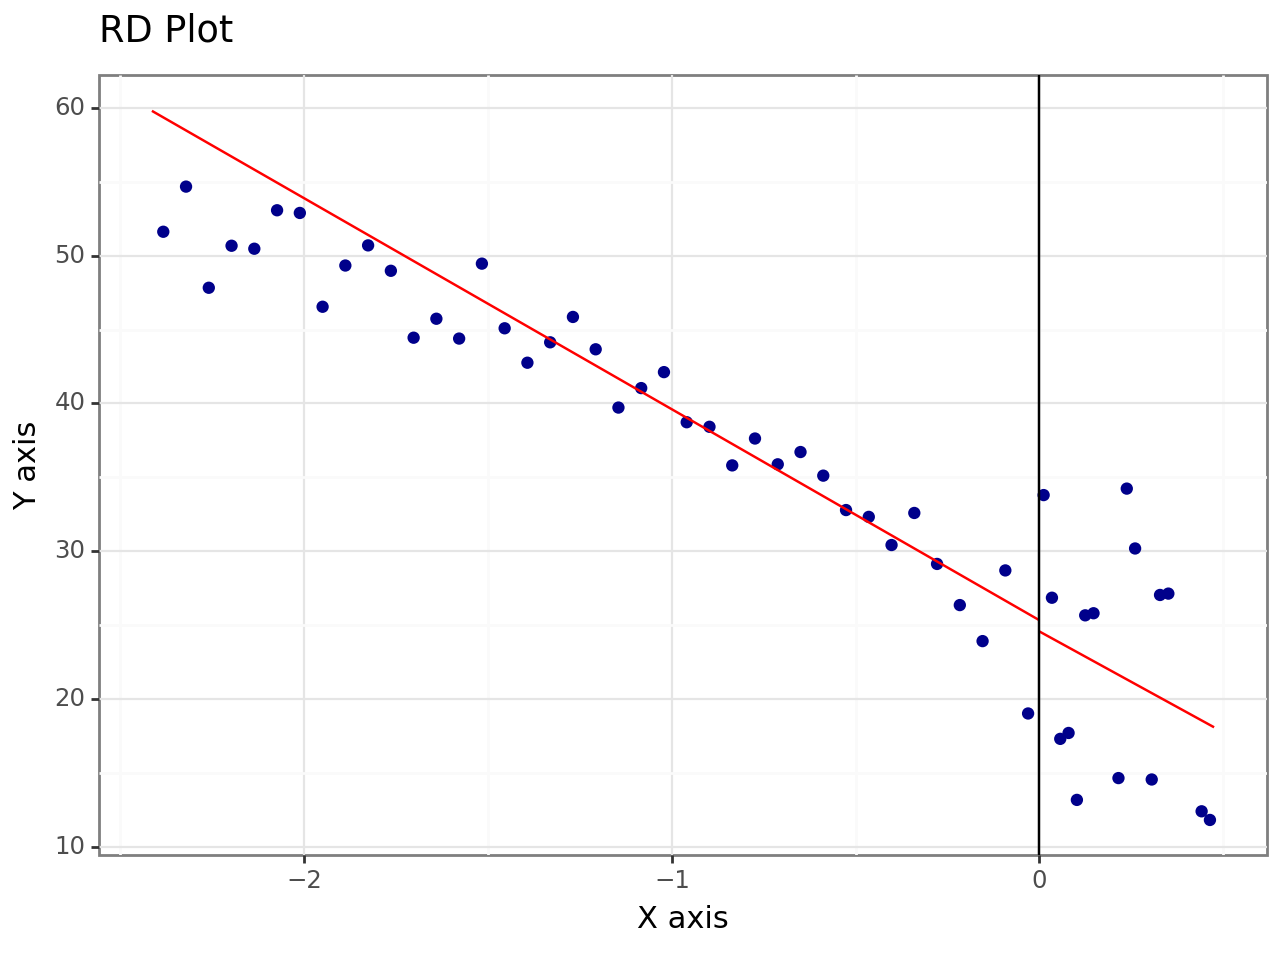


Call: rdplot
Number of Observations:                  1003
Kernel:                            Triangular
Polynomial Order Est. (p):                  1

                                Left      Right
------------------------------------------------
Number of Observations           970         33
Number of Effective Obs          969         32
Bandwith poly. fit (h)         2.414      0.475
Number of bins scale               1          1
Bins Selected                     39         21
Average Bin Length             0.062      0.023
Median Bin Length              0.062      0.023
IMSE-optimal bins               15.0        7.0
Mimicking Variance bins         39.0       21.0

Relative to IMSE-optimal:
Implied scale                    2.6        3.0
WIMSE variance weight          0.054      0.036
WIMSE bias weight              0.946      0.964


In [29]:
rdplot(df_class["Logits"], df_class["Activations"], p=1, kernel="triangular")

## Bootstrapping is too unstable

In [ ]:
est_df = pd.read_csv("local_storage/cifar10_rdd_estimates_afterrelu.csv")

In [ ]:
print(f"Valid neuron-class combinations: {est_df['Estimate'].notna().sum()/len(est_df) * 100}%")

In [ ]:
est_df.loc[est_df['Estimate'].abs().idxmax()]

In [ ]:
est_df.sort_values(by='Estimate', key=lambda est: est.abs(), ascending=False)

### The maximum RDD neuron is a bad example. Too few neurons on one side of the threshold.
### Second one, also not good.
### 3, 4,  bad.

# Inspect single neuron

In [28]:
layeri, neuroni = 6, 196
classi = 1
classname = util.cifar10_names[classi]

In [29]:
acts = np.vstack(activations_dict[layers[layeri]])[:, neuroni]

In [30]:
selected_quantile = None

In [31]:
df_class, xlims_class = produce_df_class(activations_dict, layers, labels, logits, layeri, neuroni, classi, quantile=0.25)

Should not use quantile=True` for passing it to `rdrobust`!


In [16]:
linr = sm.OLS(df_class['Logits'], sm.add_constant(df_class['Activations']))
res = linr.fit()
print(res.summary())
res.pvalues['Activations'], res.params['Activations'], res.bse['Activations']
res.pvalues['const'], res.params['const'], res.bse['const']

                            OLS Regression Results                            
Dep. Variable:                 Logits   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     74.46
Date:                Tue, 23 May 2023   Prob (F-statistic):           7.07e-16
Time:                        17:20:31   Log-Likelihood:                -916.99
No. Observations:                 254   AIC:                             1838.
Df Residuals:                     252   BIC:                             1845.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          21.5257      1.246     17.279      

(1.1657542131243247e-44, 21.525717884514933, 1.245765921614408)

# Compute regressions

In [105]:
# OLD, and unnecessary to compute, see comment in the corresponding section
# est_regression_df_pos_acts_class_true = []
# est_regression_df_full_acts_class_true = []
# est_regression_df_pos_acts_class_predicted = []
# est_regression_df_full_acts_class_predicted = []

est_regression_df_pos_acts_class_logits = []
est_regression_df_full_acts_class_logits = []

# DON'T RECOMPUTE AGAIN
est_regression_df_pos_acts_max_class = []
est_regression_df_full_acts_max_class = []

for layeri, layername in enumerate(layers):
    for neuroni in range(activations_dict[layername][0].shape[1]):
        for classi in range(logits.shape[1]):
            # OLD, and unnecessary to compute, see comment in the corresponding section
            # for labels_, est_df_list_pos, est_df_list_full in [(labels, est_regression_df_pos_acts_class_true, est_regression_df_full_acts_class_true), (predicted_labels, est_regression_df_pos_acts_class_predicted, est_regression_df_full_acts_class_predicted)]:
            for est_df_list_pos, est_df_list_full in [(est_regression_df_pos_acts_class_logits, est_regression_df_full_acts_class_logits)]:
                
                print(layeri, neuroni, classi)
                # df_class = produce_df_class(activations_dict, layers, labels_, logits, layeri, neuroni, classi)
                df_class_logits = produce_df_class_logits(activations_dict, layers, logits, layeri, neuroni, classi)
                
                pos_res, full_res = pos_full_activations_regression(df_class_logits)
                
                d_pos = {"Layer": layeri, "Layername": layername, "Neuron": neuroni, "Class": classi}
                d_pos.update(pos_res)

                d_full = {"Layer": layeri, "Layername": layername, "Neuron": neuroni, "Class": classi}
                d_full.update(full_res)
                
                est_df_list_pos.append(d_pos)
                est_df_list_full.append(d_full)
        
        # DON'T RECOMPUTE AGAIN
        # max class
        df = produce_df_max_class(activations_dict, layers, logits, layeri, neuroni)
        pos_res, full_res = pos_full_activations_regression(df)
                
        d_pos = {"Layer": layeri, "Layername": layername, "Neuron": neuroni}
        d_pos.update(pos_res)

        d_full = {"Layer": layeri, "Layername": layername, "Neuron": neuroni}
        d_full.update(full_res)
        
        est_regression_df_pos_acts_max_class.append(d_pos)
        est_regression_df_full_acts_max_class.append(d_full)

# OLD, and unnecessary to compute, see comment in the corresponding section
# est_regression_df_pos_acts_class_true = pd.DataFrame(est_regression_df_pos_acts_class_true)
# est_regression_df_pos_acts_class_true.to_csv("local_storage/cifar10_est_regression_df_pos_acts_class_true_afterrelu.csv")
# est_regression_df_full_acts_class_true = pd.DataFrame(est_regression_df_full_acts_class_true)
# est_regression_df_full_acts_class_true.to_csv("local_storage/cifar10_est_regression_df_full_acts_class_true_afterrelu.csv")
# est_regression_df_pos_acts_class_predicted = pd.DataFrame(est_regression_df_pos_acts_class_predicted)
# est_regression_df_pos_acts_class_predicted.to_csv("local_storage/cifar10_est_regression_df_pos_acts_class_predicted_afterrelu.csv")
# est_regression_df_full_acts_class_predicted = pd.DataFrame(est_regression_df_full_acts_class_predicted)
# est_regression_df_full_acts_class_predicted.to_csv("local_storage/cifar10_est_regression_df_full_acts_class_predicted_afterrelu.csv")

est_regression_df_pos_acts_class_logits = pd.DataFrame(est_regression_df_pos_acts_class_logits)
est_regression_df_pos_acts_class_logits.to_csv("local_storage/cifar10_est_regression_df_pos_acts_class_logits_afterrelu.csv")
est_regression_df_full_acts_class_logits = pd.DataFrame(est_regression_df_full_acts_class_logits)
est_regression_df_full_acts_class_logits.to_csv("local_storage/cifar10_est_regression_df_full_acts_class_logits_afterrelu.csv")

# DON'T RECOMPUTE AGAIN
est_regression_df_pos_acts_max_class = pd.DataFrame(est_regression_df_pos_acts_max_class)
est_regression_df_pos_acts_max_class.to_csv("local_storage/cifar10_est_regression_df_pos_acts_max_class_afterrelu.csv")
est_regression_df_full_acts_max_class = pd.DataFrame(est_regression_df_full_acts_max_class)
est_regression_df_full_acts_max_class.to_csv("local_storage/cifar10_est_regression_df_full_acts_max_class_afterrelu.csv")

0 0 0
0 0 1
0 0 2
0 0 3
0 0 4
0 0 5
0 0 6
0 0 7
0 0 8
0 0 9
0 1 0
0 1 1
0 1 2
0 1 3
0 1 4
0 1 5
0 1 6
0 1 7
0 1 8
0 1 9
0 2 0
0 2 1
0 2 2
0 2 3
0 2 4
0 2 5
0 2 6
0 2 7
0 2 8
0 2 9
0 3 0
0 3 1
0 3 2
0 3 3
0 3 4
0 3 5
0 3 6
0 3 7
0 3 8
0 3 9
0 4 0
0 4 1
0 4 2
0 4 3
0 4 4
0 4 5
0 4 6
0 4 7
0 4 8
0 4 9
0 5 0
0 5 1
0 5 2
0 5 3
0 5 4
0 5 5
0 5 6
0 5 7
0 5 8
0 5 9
0 6 0
0 6 1
0 6 2
0 6 3
0 6 4
0 6 5
0 6 6
0 6 7
0 6 8
0 6 9
0 7 0
0 7 1
0 7 2
0 7 3
0 7 4
0 7 5
0 7 6
0 7 7
0 7 8
0 7 9
0 8 0
0 8 1
0 8 2
0 8 3
0 8 4
0 8 5
0 8 6
0 8 7
0 8 8
0 8 9
0 9 0
0 9 1
0 9 2
0 9 3
0 9 4
0 9 5
0 9 6
0 9 7
0 9 8
0 9 9
0 10 0
0 10 1
0 10 2
0 10 3
0 10 4
0 10 5
0 10 6
0 10 7
0 10 8
0 10 9
0 11 0
0 11 1
0 11 2
0 11 3
0 11 4
0 11 5
0 11 6
0 11 7
0 11 8
0 11 9
0 12 0
0 12 1
0 12 2
0 12 3
0 12 4
0 12 5
0 12 6
0 12 7
0 12 8
0 12 9
0 13 0
0 13 1
0 13 2
0 13 3
0 13 4
0 13 5
0 13 6
0 13 7
0 13 8
0 13 9
0 14 0
0 14 1
0 14 2
0 14 3
0 14 4
0 14 5
0 14 6
0 14 7
0 14 8
0 14 9
0 15 0
0 15 1
0 15 2
0 15 3
0 15 4
0 15 5
0 15 6
0

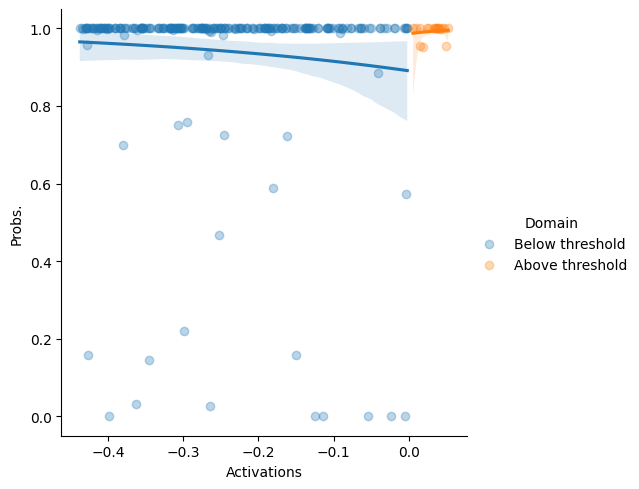

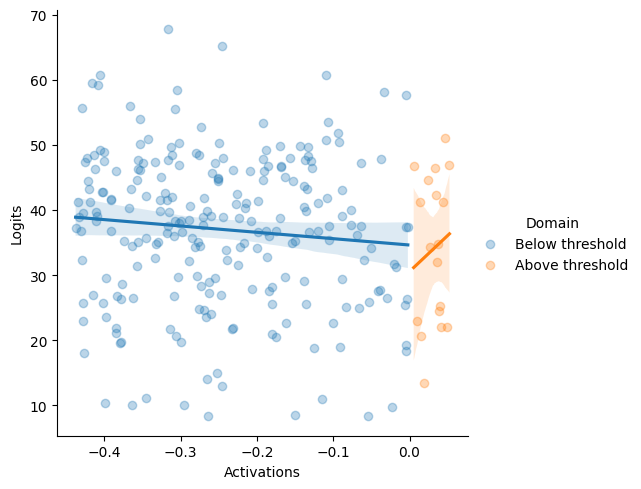

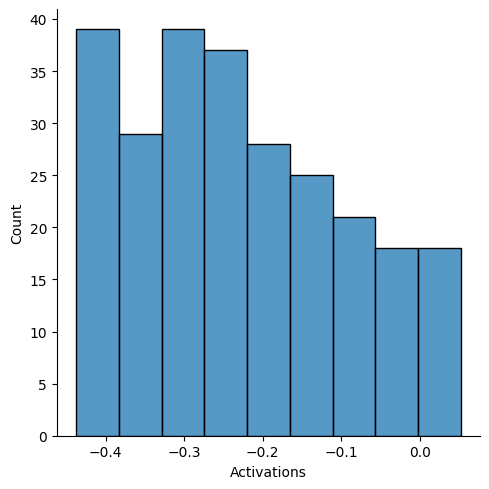

In [33]:
sns.lmplot(x = "Activations", y = "Probs.", data=df_class, hue="Domain", logistic=True, scatter_kws={'alpha':0.3})
sns.lmplot(x = "Activations", y = "Logits", data=df_class, hue="Domain", scatter_kws={'alpha':0.3})
sns.displot(df_class, x="Activations")

In [35]:
# bootn = 1000
# bootinds = np.random.randint(0, len(df_class)-1, size=(bootn, len(df_class)))

# estimates_left = []
# estimates_right = []
# for boot in bootinds:
#     df_class_boot = df_class.loc[boot]
#     l, r = est_left_right(df_class_boot, xlims_class) # the xlims are not exactly correct now.. but i think this is like a hparam
#     estimates_left.append(l), estimates_right.append(r)

# diffs = np.array(estimates_right)[:, np.newaxis] - np.array(estimates_left)[np.newaxis, :]
# np.nanmean(diffs)

In [36]:
# bootn = 1000
# results = Parallel(n_jobs=4)(delayed(est_left_right)(df_class.sample(frac=1, replace=True), xlims_class)
#                           for _ in range(bootn))
# results = np.array(results)
# diffs = results[:, 1, np.newaxis] - results[np.newaxis, :, 0]
# np.nanmean(diffs), np.nanstd(diffs)

In [39]:
quantile = 0.25
est_df_boot = []
for layeri, layername in enumerate(layers):
    for neuroni in range(activations_dict[layername][0].shape[1]):
        for classi in range(logits.shape[1]):
            print(layeri, neuroni, classi)
            df_class, xlims_class = produce_df_class(activations_dict, layers, labels, logits, layeri, neuroni, classi, quantile=quantile)
            est, est_std = bootstrapped_rdd(df_class, xlims_class)
            d = {"Layer": layeri, "Layername": layername, "Neuron": neuroni, "Class": classi, "Estimate": est, "Estimate Std.": est_std}
            est_df_boot.append(d)
est_df_boot = pd.DataFrame(est_df_boot)

est_df_boot.to_csv("local_storage/cifar10_rdd_estimates_boot_afterrelu.csv")

0 0 0
Should not use quantile=True` for passing it to `rdrobust`!
0 0 1
Should not use quantile=True` for passing it to `rdrobust`!
0 0 2
Should not use quantile=True` for passing it to `rdrobust`!
0 0 3
Should not use quantile=True` for passing it to `rdrobust`!
0 0 4
Should not use quantile=True` for passing it to `rdrobust`!
0 0 5
Should not use quantile=True` for passing it to `rdrobust`!
0 0 6
Should not use quantile=True` for passing it to `rdrobust`!
0 0 7
Should not use quantile=True` for passing it to `rdrobust`!
0 0 8
Should not use quantile=True` for passing it to `rdrobust`!
0 0 9
Should not use quantile=True` for passing it to `rdrobust`!
0 1 0
Should not use quantile=True` for passing it to `rdrobust`!
0 1 1
Should not use quantile=True` for passing it to `rdrobust`!
0 1 2
Should not use quantile=True` for passing it to `rdrobust`!
0 1 3
Should not use quantile=True` for passing it to `rdrobust`!
0 1 4
Should not use quantile=True` for passing it to `rdrobust`!
0 1 5
Shou

In [ ]:
df_class, xlims_class = produce_df_class(activations_dict, layers, labels, logits, 0, 0, 0, quantile=quantile)
# est, est_std = 
bootstrapped_rdd(df_class, xlims_class)

In [ ]:
df_class, xlims_class = produce_df_class(activations_dict, layers, labels, logits, 0, 0, 0, quantile=quantile)
# est, est_std = 
est_left_right(df_class.sample(frac=1, replace=True), xlims_class)

In [38]:
estimate_rdd_effect(df_class['Logits'], df_class['Activations'])

nan

In [ ]:
est_df_boot

In [22]:
for bwselect in ["mserd", "msetwo", "certwo"]:
    est_df = []
    for layeri, layername in enumerate(layers):
        for neuroni in range(activations_dict[layername][0].shape[1]):
            for classi in range(logits.shape[1]):
                df_class = produce_df_class(activations_dict, layers, labels, logits, layeri, neuroni, classi)
                est = estimate_rdd_effect(df_class['Logits'], df_class['Activations'], bwselect=bwselect)
                # print(f"Layer: {layeri}, Neuron: {neuroni}, Class: {classi}, Estimate: {est}")
                d = {"Layer": layeri, "Layername": layername, "Neuron": neuroni, "Class": classi, "Estimate": est}
                est_df.append(d)
    est_df = pd.DataFrame(est_df)

    est_df.to_csv(f"local_storage/cifar10_rdd_estimates_{bwselect}_afterrelu.csv")

rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:512: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdrobust.py:689: RuntimeWarning: invalid value encountered in sqrt


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:502: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/funs.py:312: RuntimeWarning: invalid value encountered in scalar divide


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:520: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdrobust.py:688: RuntimeWarning: invalid value encountered in sqrt


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:449: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:460: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:436: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:435: RuntimeWarning: divide by zero encountered in scalar divide


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:435: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:450: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:436: RuntimeWarning: divide by zero encountered in scalar divide


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:461: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

In [31]:
for bwselect in ["mserd", "msetwo", "certwo"]:
    loaded_df = pd.read_csv(f"local_storage/cifar10_rdd_estimates_{bwselect}_afterrelu.csv")
    perc = loaded_df["Estimate"].notna().sum()/len(loaded_df["Estimate"])
    print(f"Valid neuron-class combinations for {bwselect}: {perc * 100}%")

Valid neuron-class combinations for mserd: 5.518134715025907%
Valid neuron-class combinations for msetwo: 6.818652849740933%
Valid neuron-class combinations for certwo: 6.44559585492228%


In [25]:
for bwselect in ["mserd", "msetwo", "certwo"]:
    est_df = []
    for layeri, layername in enumerate(layers):
        for neuroni in range(activations_dict[layername][0].shape[1]):
            for classi in range(logits.shape[1]):
                df_class = produce_df_class(activations_dict, layers, labels, logits, layeri, neuroni, classi)
                est = estimate_rdd_effect(df_class['Log. Probs.'], df_class['Activations'], bwselect=bwselect)
                # print(f"Layer: {layeri}, Neuron: {neuroni}, Class: {classi}, Estimate: {est}")
                d = {"Layer": layeri, "Layername": layername, "Neuron": neuroni, "Class": classi, "Estimate": est}
                est_df.append(d)
    est_df = pd.DataFrame(est_df)

    est_df.to_csv(f"local_storage/cifar10_rdd_estimates_logprobs_{bwselect}_afterrelu.csv")

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:512: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/funs.py:312: RuntimeWarning: invalid value encountered in scalar divide


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:520: RuntimeWarning: divide by zero encountered in scalar divide


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:502: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdrobust.py:693: RuntimeWarning: divide by zero encountered in divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdrobust.py:693: RuntimeWarning: invalid value encountered in divide


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:520: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdrobust.py:688: RuntimeWarning: invalid value encountered in sqrt
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdrobust.py:689: RuntimeWarning: invalid value encountered in sqrt


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:512: RuntimeWarning: divide by zero encountered in scalar divide


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:461: RuntimeWarning: divide by zero encountered in scalar divide


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/funs.py:275: RuntimeWarning: divide by zero encountered in divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/funs.py:281: RuntimeWarning: invalid value encountered in multiply


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:449: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:460: RuntimeWarning: divide by zero encountered in scalar divide


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:449: RuntimeWarning: divide by zero encountered in scalar divide


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:435: RuntimeWarning: invalid value encountered in scalar divide


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:435: RuntimeWarning: divide by zero encountered in scalar divide


rdorobust failed
rdorobust failed
rdorobust failed


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:460: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:436: RuntimeWarning: invalid value encountered in scalar divide


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:436: RuntimeWarning: divide by zero encountered in scalar divide


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:450: RuntimeWarning: divide by zero encountered in scalar divide


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:450: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:436: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:461: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:435: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

In [32]:
# thats similar to before
for bwselect in ["mserd", "msetwo", "certwo"]:
    loaded_df = pd.read_csv(f"local_storage/cifar10_rdd_estimates_logprobs_{bwselect}_afterrelu.csv")
    perc = loaded_df["Estimate"].notna().sum()/len(loaded_df["Estimate"])
    print(f"Valid neuron-class combinations for {bwselect}: {perc * 100}%")

Valid neuron-class combinations for mserd: 2.8756476683937824%
Valid neuron-class combinations for msetwo: 6.865284974093264%
Valid neuron-class combinations for certwo: 6.22279792746114%


In [ ]:
# TODO: check how many failed..
# try different bandwidth selectors: certwo, msetwo
# why do so much more fail now? what happens for log of prob (like it was before...)

In [ ]:
(est_df["Estimate"] == est_df["Estimate"]).sum(), (est_df["Estimate"] == est_df["Estimate"]).sum()/(len(est_df["Estimate"]))

In [ ]:
# inlims_acts = acts[inlims]
# logits_all = np.max(logits, axis=1)[inlims]

# probs_all = np.max(probs, axis=1)[inlims]

# logprobs_all = np.log(probs_all)
# domain_all = np.array(["Above threshold" if a >= 0 else "Below threshold" for a in acts])[inlims]

# df_all = pd.DataFrame({"Log. Probs.": logprobs_all, 
#                    "Probs.": probs_all,
#                    "Logits": logits_all,
#                    "Activations": inlims_acts, "Domain": domain_all})                   

In [ ]:
#DONE: i need the log probs of the classes
# check accuracy of logprobs. this is fine :)
# (np.vstack(activations_dict[layers[-1]]).argmax(axis=1) == labels).sum()/len(labels)

In [ ]:
# sns.lmplot(x = "Activations", y = "Probs.", data=df_all, hue="Domain", logistic=True, scatter_kws={'alpha':0.3})
# sns.lmplot(x = "Activations", y = "Log. Probs.", data=df_all, hue="Domain", scatter_kws={'alpha':0.3})
# sns.lmplot(x = "Activations", y = "Logits", data=df_all, hue="Domain", scatter_kws={'alpha':0.3})
# sns.displot(df_all, x="Activations")

In [ ]:
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Binomial

#TODO: what happens if adding one vector?

df_bt = df_class.loc[df_class["Domain"] == "Below threshold"]
logisitic_regression_bt = GLM(df_bt["Probs."], df_bt["Activations"], family=Binomial()).fit()

df_at = df_class.loc[df_class["Domain"] == "Above threshold"]
logisitic_regression_at = GLM(df_at["Probs."], df_at["Activations"], family=Binomial()).fit()

logisitic_regression_bt_with_intercept = GLM(df_bt["Probs."], np.c_[np.ones(len(df_bt["Activations"])), df_bt["Activations"]], family=Binomial()).fit()
logisitic_regression_at_with_intercept = GLM(df_at["Probs."], np.c_[np.ones(len(df_at["Activations"])), df_at["Activations"]], family=Binomial()).fit()

In [ ]:
logisitic_regression_bt.predict(-0.001), logisitic_regression_at.predict(0.001), logisitic_regression_bt_with_intercept.predict([1, -0.001]), logisitic_regression_at_with_intercept.predict([1, 0.001])

In [ ]:
#TODO: that it still too bad... seaborn used bootstrapping. Copy it from seaborn. Strip the plotting stuff

#TODO: implement triangular kernel weighting

#TODO: the difference between means might not be the best. but maybe one can compute the avg. of distances from the bootstrap samples
#TODO: can this be used to classify inhibitory and excitatory neurons?

#TODO: use all samples and weigh samples according to classes -> no, Wait

# What might be good RDDs?
# All samples to their max log prob (any class) -> reveals if a neuron is generally excitatory or inhibitory and how relevant it generally is
# For a class, is this neuron relevant? This should really focus on samples from that class

# regressing the logits is more close to the jacobian of the output neurons

In [ ]:
# Why does seaborn add ones to the X used in GLM? It's the intercept. like sm.add_constant

In [ ]:
rdplot(y=df_class["Logits"], x=df_class["Activations"], binselect="esmvpr", p=1, kernel='triangular')

In [ ]:
rdrobust(y=df_class["Logits"], x=df_class["Activations"])

In [ ]:
rdrobust(y=df_class["Probs."], x=df_class["Activations"])

In [ ]:
out = rdrobust(y=df_class["Log. Probs."], x=df_class["Activations"])
out

In [ ]:
alpha = 0.05

In [ ]:
if pval >= alpha:
    est = np.nan
else:
    cis = out.ci.loc["Robust"].to_numpy()

    # if they have different signs, use the middle
    all_same = np.all(np.sign(cis) == np.sign(cis)[0])
    if all_same:
        est = np.abs(cis).min() * np.sign(cis)[0]
    else:
        est = np.mean(cis)

est

In [ ]:
estimate_rdd_effect(df_class["Log. Probs."], df_class["Activations"])